<p style="font-size:30px;">The Relationship between Pollution and Economic Activities</p>

<p style="font-size:30px;">Sara Almadani</p>

<p style="font-size:30px;">Understanding the Dataset:</p>

In [1]:
# Import libraries
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker
import scipy.stats as stats
import pandas as pd
import os
from statsmodels.tsa.stattools import adfuller
from scipy.stats import linregress
import statsmodels.api as sm

In [ ]:
# The following codes should be run only once to calculate the quarterly data for:
# (1) Only one pollution variable: dust PM2.5
# (2) All dust variables
# Hence, I ran them separately.
# Quarterly means are saved to: /home/salmadan/Desktop/groups/ESS3/Sara/daily/mean/quarterly_means.nc
# Quarterly means for all variables are saved to: /home/salmadan/Desktop/groups/ESS3/Sara/daily/mean/quarterly_means_all.nc

# Dust PM2.5
# Step 1: List all files ending with '_tot.nc'
#files = sorted(glob.glob("/home/salmadan/Desktop/groups/ESS3/Sara/daily/mean/*_tot.nc"))
# Step 2: Filter out missing files
#valid_files = [file for file in files if os.path.exists(file)]
#if not valid_files:
#    raise FileNotFoundError("No valid files found to process!")
# Step 3: Load datasets
#ds = xr.open_mfdataset(valid_files, combine='by_coords')
# Step 4: Select variable of interest and resample to quarterly means
#dust_pm25 = ds['dust_pm25']  # Replace with your variable name if needed
#quarterly_means = dust_pm25.resample(time='Q').mean()
# Step 5: Save the aggregated data to a NetCDF file
#output_path = "/home/salmadan/Desktop/groups/ESS3/Sara/daily/mean/quarterly_means.nc"
#quarterly_means.to_netcdf(output_path)
#print(f"Quarterly means saved to: {output_path}")


# All pollution variables: ['dust_pm25', 'dust_pm10', 'dust_aod', 'pm25', 'pm10']
#Step 1: List and filter files
#files = sorted(glob.glob("/home/salmadan/Desktop/groups/ESS3/Sara/daily/mean/*_tot.nc"))
#valid_files = [f for f in files if os.path.exists(f)]

#if not valid_files:
#    raise FileNotFoundError("No valid files found to process!")
# Step 2: Load files with chunking
#ds = xr.open_mfdataset(valid_files, combine='by_coords', chunks={'time': 10})
# Step 3: Select and process all relevant variables
#variables = ['dust_pm25', 'dust_pm10', 'dust_aod', 'pm25', 'pm10']
#quarterly_means = {}

#for var in variables:
#    if var in ds.variables:
#        # Resample the variable to quarterly means
#        quarterly_means[var] = ds[var].resample(time='QE').mean(skipna=True)
#    else:
#        print(f"Warning: Variable '{var}' not found in dataset!")
# Combine all processed variables into a single dataset
#ds_quarterly_means = xr.Dataset(quarterly_means)
# Step 4: Save the results with compression
#output_path = "/home/salmadan/Desktop/groups/ESS3/Sara/daily/mean/quarterly_means_all.nc"
#encoding = {var: {'zlib': True, 'complevel': 5} for var in ds_quarterly_means.data_vars}
#ds_quarterly_means.to_netcdf(output_path, encoding=encoding)
#print(f"Quarterly means saved to: {output_path}")

In [2]:
#Load the quarterly means file for only one pollution variable dust pm2.5
processed_file_path = "/home/salmadan/Desktop/groups/ESS3/Sara/daily/mean/quarterly_means.nc"
ds_quarterly = xr.open_dataset(processed_file_path)
dust_pm25 = ds_quarterly['dust_pm25']

In [3]:
#Load GDP data
gdp_file_path = "/home/salmadan/GDPperCapita.csv"
gdp_df = pd.read_csv(gdp_file_path)

# Convert 'Date' to datetime format
gdp_df['time'] = pd.to_datetime(gdp_df['Date'])

# Drop 'Date' to avoid duplication
gdp_df = gdp_df.drop(columns=['Date'], errors='ignore')

In [4]:
# Load the quarterly means file for all pollution variables ['dust_pm25', 'dust_pm10', 'dust_aod', 'pm25', 'pm10']
processed_file_path = "/home/salmadan/Desktop/groups/ESS3/Sara/daily/mean/quarterly_means_all.nc"
ds_quarterly = xr.open_dataset(processed_file_path)

# Extract relevant variables for analysis
dust_pm25 = ds_quarterly['dust_pm25']
dust_pm10 = ds_quarterly['dust_pm10']
dust_aod = ds_quarterly['dust_aod']
pm25 = ds_quarterly['pm25']
pm10 = ds_quarterly['pm10']

In [5]:
# Load National Activity Index data
NAI_file_path = "/home/salmadan/CFNAI.csv"
# Read the monthly data into a DataFrame
monthly_data = pd.read_csv(NAI_file_path)
# Convert the 'DATE' column to datetime format
monthly_data['DATE'] = pd.to_datetime(monthly_data['DATE'])
# Set the 'DATE' column as the index
monthly_data.set_index('DATE', inplace=True)
# Resample to quarterly frequency and calculate the mean for each quarter
# Specify 'Q-DEC' to indicate quarters ending in December
quarterly_data = monthly_data.resample('QE-DEC').mean()
# Reset the index to make DATE a column again
quarterly_data.reset_index(inplace=True)
# Rename the DATE column to match your other data (if needed)
quarterly_data.rename(columns={'DATE': 'Quarter'}, inplace=True)
# Display the quarterly data
print(quarterly_data)

      Quarter     CFNAI
0  2003-03-31 -0.086667
1  2003-06-30 -0.170000
2  2003-09-30  0.096667
3  2003-12-31  0.220000
4  2004-03-31  0.343333
..        ...       ...
75 2021-12-31  0.623333
76 2022-03-31  0.380000
77 2022-06-30 -0.170000
78 2022-09-30  0.136667
79 2022-12-31 -0.363333

[80 rows x 2 columns]


<p style="font-size:30px;">Summary statistics: (mean, standard deviation, etc.)</p>

In [5]:
# Calculate summary statistics for the GDP data
summary_gdp = gdp_df.describe()
print("\nSummary Statistics for GDP data:\n", summary_gdp)


Summary Statistics for GDP data:
                 GDP                 time
count     80.000000                   80
mean   57375.800000  2012-11-15 04:30:00
min    50462.000000  2003-01-01 00:00:00
25%    54386.000000  2007-12-09 00:00:00
50%    55858.000000  2012-11-16 00:00:00
75%    60242.750000  2017-10-24 00:00:00
max    66575.000000  2022-10-01 00:00:00
std     4094.823263                  NaN


The NaN for the time column indicates that certain statistics (like standard deviation) cannot be computed for datetime data. However, statistics like min, max, and percentiles (25%, 50%, 75%) are valid for datetime and are shown correctly in the output.

In [6]:
# Calculate summary statistics for the National Activity Index data
summary_CFNAI = quarterly_data['CFNAI'].describe()
# Display the summary statistics
print("Summary Statistics for National Activity Index data:")
print(summary_CFNAI)

Summary Statistics for National Activity Index data:
count    80.000000
mean     -0.110792
std       0.580346
min      -2.390000
25%      -0.170000
50%      -0.023333
75%       0.125000
max       1.430000
Name: CFNAI, dtype: float64


In [6]:
# Calculate summary statistics for all pollution variables
dust_pm25_stats_all = dust_pm25.to_dataframe().describe()
dust_pm10_stats = dust_pm10.to_dataframe().describe()
dust_aod_stats = dust_aod.to_dataframe().describe()
pm25_stats = pm25.to_dataframe().describe()
pm10_stats = pm10.to_dataframe().describe()

# Print the statistics for each variable
print("Summary Statistics for dust_pm25 (quarterly_means_all.nc):\n", dust_pm25_stats_all)
print("Summary Statistics for dust_pm10 (quarterly_means_all.nc):\n", dust_pm10_stats)
print("Summary Statistics for dust_aod (quarterly_means_all.nc):\n", dust_aod_stats)
print("Summary Statistics for pm25 (quarterly_means_all.nc):\n", pm25_stats)
print("Summary Statistics for pm10 (quarterly_means_all.nc):\n", pm10_stats)

Summary Statistics for dust_pm25 (quarterly_means_all.nc):
           dust_pm25
count  5.184000e+08
mean   2.678963e+00
std    1.029113e+01
min    1.384708e-02
25%    1.930266e-01
50%    4.894370e-01
75%    1.030351e+00
max    5.900775e+02
Summary Statistics for dust_pm10 (quarterly_means_all.nc):
           dust_pm10
count  5.184000e+08
mean   9.605349e+00
std    3.909495e+01
min    4.280833e-02
25%    6.937454e-01
50%    1.925928e+00
75%    4.113326e+00
max    2.858380e+03
Summary Statistics for dust_aod (quarterly_means_all.nc):
            dust_aod
count  5.184000e+08
mean   1.854374e-02
std    4.725541e-02
min    2.517246e-04
25%    2.520401e-03
50%    6.193466e-03
75%    1.280453e-02
max    9.432814e-01
Summary Statistics for pm25 (quarterly_means_all.nc):
                pm25
count  5.184000e+08
mean   9.026587e+00
std    1.024526e+01
min    1.426357e+00
25%    3.938530e+00
50%    7.147197e+00
75%    1.009495e+01
max    5.820370e+02
Summary Statistics for pm10 (quarterly_means_a

<p style="font-size:30px;">Time Series Plots</p>

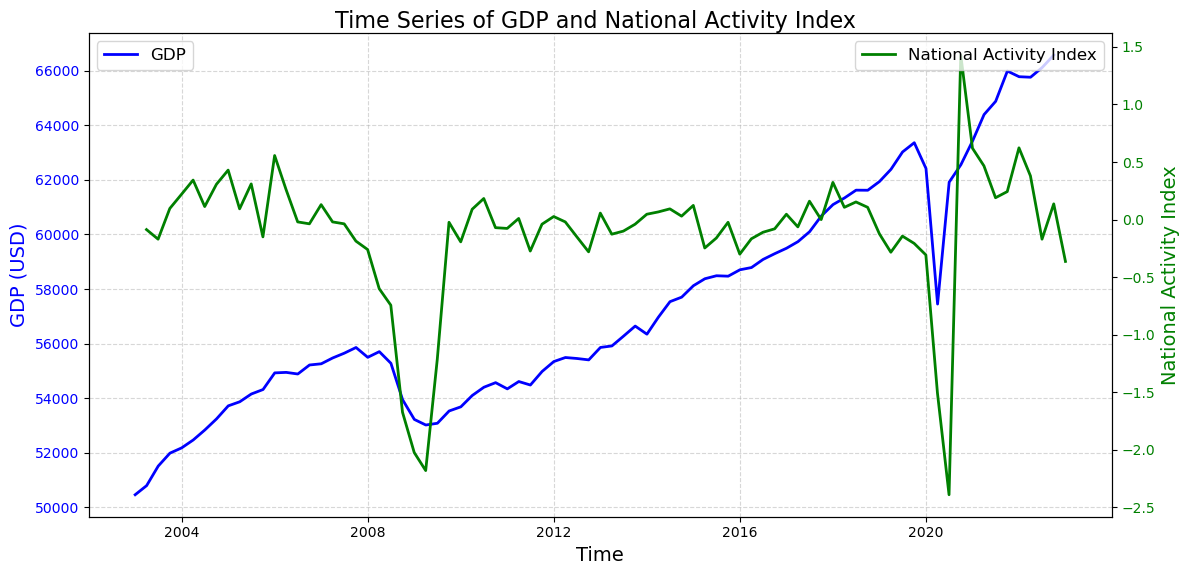

In [7]:
# Plot the time series of GDP and National Activity Index
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot GDP on the primary y-axis
ax1.plot(gdp_df['time'], gdp_df['GDP'], label="GDP", color='blue', linewidth=2)
ax1.set_xlabel("Time", fontsize=14)
ax1.set_ylabel("GDP (USD)", color='blue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(visible=True, linestyle='--', alpha=0.5)

# Create a secondary y-axis for National Activity Index
ax2 = ax1.twinx()
ax2.plot(quarterly_data['Quarter'], quarterly_data['CFNAI'], label="National Activity Index", color='green', linewidth=2)
ax2.set_ylabel("National Activity Index", color='green', fontsize=14)
ax2.tick_params(axis='y', labelcolor='green')

# Add a title and legend
fig.suptitle("Time Series of GDP and National Activity Index", fontsize=16, y=0.95)
ax1.legend(loc="upper left", fontsize=12)
ax2.legend(loc="upper right", fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

The figure shows: (1) Trend: There is a clear upward trend in GDP per capita and National Activity Index over time, with noticeable dips during economic downturns (e.g., the 2008 financial crisis and the COVID-19 pandemic in 2020). (2) Non-Stationarity: The series appears non-stationary due to its upward trend and lack of constant mean or variance over time.

Stationarity is so important to avoid spurious regression. Two tests: augmented Dickey–Fuller (ADF) or autocorrelation function (ACF) to check Stationarity. 

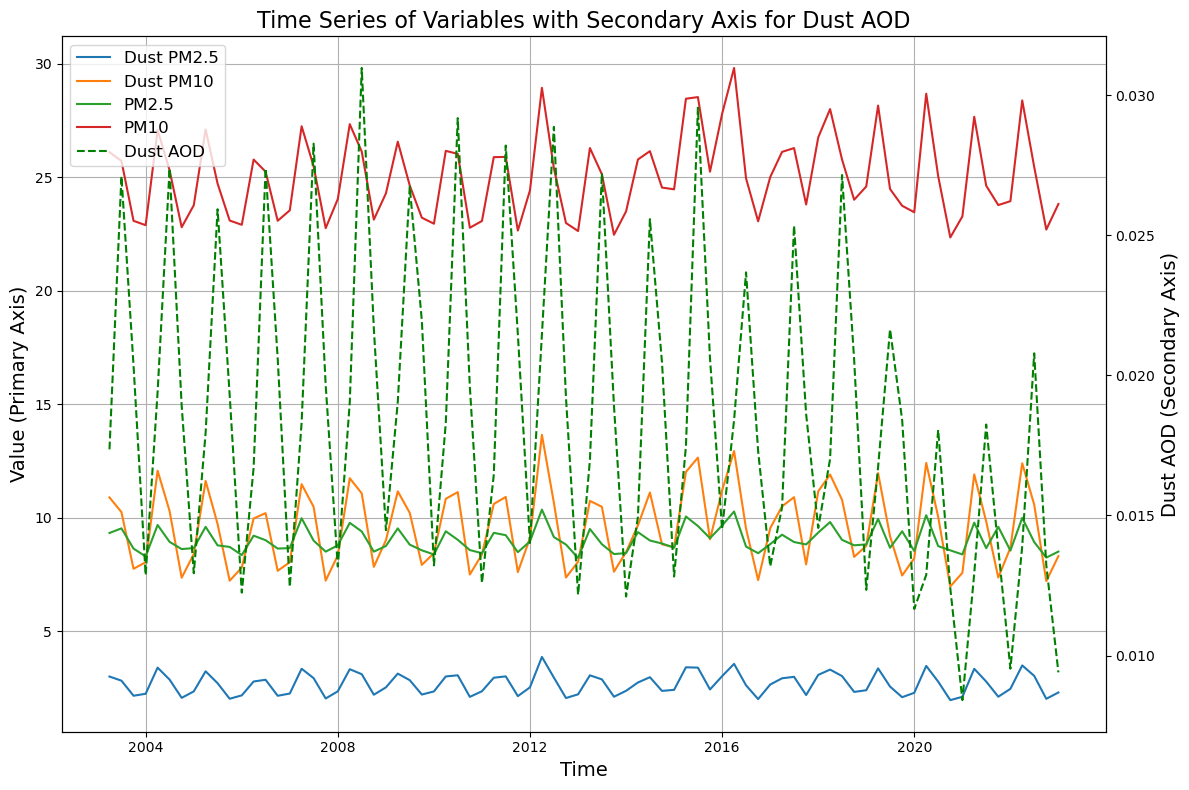

In [8]:
# Plot the pollution variables time series
# Define the variables for plotting
variables = {
    'Dust PM2.5': dust_pm25,
    'Dust PM10': dust_pm10,
    'Dust AOD': dust_aod,
    'PM2.5': pm25,
    'PM10': pm10
}

# Initialize the figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot all variables except Dust AOD on the primary axis
for variable_name, data in variables.items():
    if variable_name != 'Dust AOD':
        # Compute the mean over spatial dimensions if data is multidimensional
        if len(data.dims) > 1:
            data_mean = data.mean(dim=['lat', 'lon'])
        else:
            data_mean = data
        
        # Plot the data on the primary axis
        ax1.plot(data_mean['time'], data_mean, label=variable_name)

# Customize the primary axis
ax1.set_xlabel("Time", fontsize=14)
ax1.set_ylabel("Value (Primary Axis)", fontsize=14)
ax1.set_title("Time Series of Variables with Secondary Axis for Dust AOD", fontsize=16)
ax1.grid()

# Create a secondary axis for Dust AOD
ax2 = ax1.twinx()
dust_aod_mean = dust_aod.mean(dim=['lat', 'lon'])  # Compute spatial mean
ax2.plot(dust_aod_mean['time'], dust_aod_mean, 'g--', label='Dust AOD')  # Dashed green line for Dust AOD
ax2.set_ylabel("Dust AOD (Secondary Axis)", fontsize=14)

# Combine the legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, fontsize=12, loc='upper left')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


<p style="font-size:30px;">ADF Test to check for stationarity, which is so important to avoid spurious regression:</p>

In [8]:
# Perform the ADF test on the GDP series
adf_result = adfuller(gdp_df['GDP'])

# Print the test results
print("ADF Test Results for GDP per Capita:")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

# Interpretation
if adf_result[1] <= 0.05:
    print("\nThe null hypothesis of the ADF test is rejected.")
    print("This indicates the time series is stationary.")
else:
    print("\nThe null hypothesis of the ADF test cannot be rejected.")
    print("This indicates the time series is non-stationary.")

ADF Test Results for GDP per Capita:
ADF Statistic: -0.0001601437479453625
p-value: 0.9585188402803101
Critical Values:
   1%: -3.517113604831504
   5%: -2.8993754262546574
   10%: -2.5869547797501644

The null hypothesis of the ADF test cannot be rejected.
This indicates the time series is non-stationary.


In [9]:
# Perform the ADF test on the 'CFNAI' column of the quarterly data
adf_result = adfuller(quarterly_data['CFNAI'])

# Display the ADF test results
print("ADF Test Results for National Activity Index:")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

# Interpretation of the results
if adf_result[1] < 0.05:
    print("The null hypothesis is rejected. The time series is stationary.")
else:
    print("The null hypothesis cannot be rejected. The time series is non-stationary.")

ADF Test Results for National Activity Index:
ADF Statistic: -4.779652759697609
p-value: 5.947571272570634e-05
Critical Values:
   1%: -3.5159766913976376
   5%: -2.898885703483903
   10%: -2.5866935058484217
The null hypothesis is rejected. The time series is stationary.


In [7]:
# Perform the ADF test on the pollution variables
# Define the variables
variables = {
    'Dust PM2.5': dust_pm25,
    'Dust PM10': dust_pm10,
    'Dust AOD': dust_aod,
    'PM2.5': pm25,
    'PM10': pm10
}

# Perform ADF test for each variable
for var_name, var_data in variables.items():
    print(f"\n--- ADF Test Results for {var_name} ---")
    
    # Compute the mean over spatial dimensions (lat, lon) to get a time series
    if len(var_data.dims) > 1:
        var_series = var_data.mean(dim=['lat', 'lon']).to_pandas()
    else:
        var_series = var_data.to_pandas()
    
    # Perform the ADF test
    adf_result = adfuller(var_series)
    
    # Print the results
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"   {key}: {value}")
    
    # Interpretation
    if adf_result[1] <= 0.05:
        print("The null hypothesis is rejected. The time series is stationary.")
    else:
        print("The null hypothesis cannot be rejected. The time series is non-stationary.")



--- ADF Test Results for Dust PM2.5 ---
ADF Statistic: -4.446668857036481
p-value: 0.0002451950191960256
Critical Values:
   1%: -3.5219803175527606
   5%: -2.9014701097664504
   10%: -2.58807215485756
The null hypothesis is rejected. The time series is stationary.

--- ADF Test Results for Dust PM10 ---
ADF Statistic: -3.915636425620328
p-value: 0.0019227382133092815
Critical Values:
   1%: -3.5219803175527606
   5%: -2.9014701097664504
   10%: -2.58807215485756
The null hypothesis is rejected. The time series is stationary.

--- ADF Test Results for Dust AOD ---
ADF Statistic: 1.7568247045545657
p-value: 0.9982594293765783
Critical Values:
   1%: -3.530398990560757
   5%: -2.9050874099328317
   10%: -2.5900010121107266
The null hypothesis cannot be rejected. The time series is non-stationary.

--- ADF Test Results for PM2.5 ---
ADF Statistic: -3.235168738946923
p-value: 0.01803711682051183
Critical Values:
   1%: -3.5274258688046647
   5%: -2.903810816326531
   10%: -2.5893204081632

The ADF test results show that Dust PM2.5, Dust PM10, and PM2.5 are stationary time series, as their null hypotheses were rejected with p-values below 0.05. However, Dust AOD and PM10 are non-stationary, as their p-values are higher than 0.05, indicating that the null hypothesis of non-stationarity cannot be rejected. Stationary variables can be used directly in time series modeling, while non-stationary variables may require transformations like differencing to make them stationary. This distinction is important to ensure the reliability of further analyses.

![GDP Per Capita and Air Pollution](Figure.png)

Vandenbroucke and Zhu (2017) used the logarithm of GDP per capita and the logarithm of PM2.5 emissions in their analysis, as shown in the above figure. The reason for using logarithmic transformations is twofold. First, it helps linearize relationships that might otherwise be nonlinear, allowing for a clearer and more interpretable regression model. Second, logarithmic scales reduce the impact of extreme values, making the data less skewed and ensuring that the analysis is not disproportionately influenced by outliers. This approach is particularly useful when comparing variables that span several orders of magnitude, such as GDP and PM2.5 emissions, providing a more balanced representation of their relationship.

<p style="font-size:20px;">Natural Logarithm:</p>

In [10]:
# Apply natural logarithm to 'GDP' and store in a new column 'Log_GDP'
gdp_df['Log_GDP'] = np.log(gdp_df['GDP'])

# Compute the first difference of the log-transformed GDP and store in 'Log_GDP_diff'
gdp_df['Log_GDP_diff'] = gdp_df['Log_GDP'].diff()

# Drop the first row which will have NaN after differencing
gdp_df = gdp_df.dropna(subset=['Log_GDP_diff']).reset_index(drop=True)

In [8]:
# Summary statistics for Log_GDP_diff
summary_stats = gdp_df['Log_GDP_diff'].describe()

# Print the summary statistics
print("Summary Statistics for Log_GDP_diff:")
print(summary_stats)

Summary Statistics for Log_GDP_diff:
count    79.000000
mean      0.003508
std       0.014211
min      -0.082924
25%       0.001095
50%       0.004378
75%       0.007205
max       0.074865
Name: Log_GDP_diff, dtype: float64


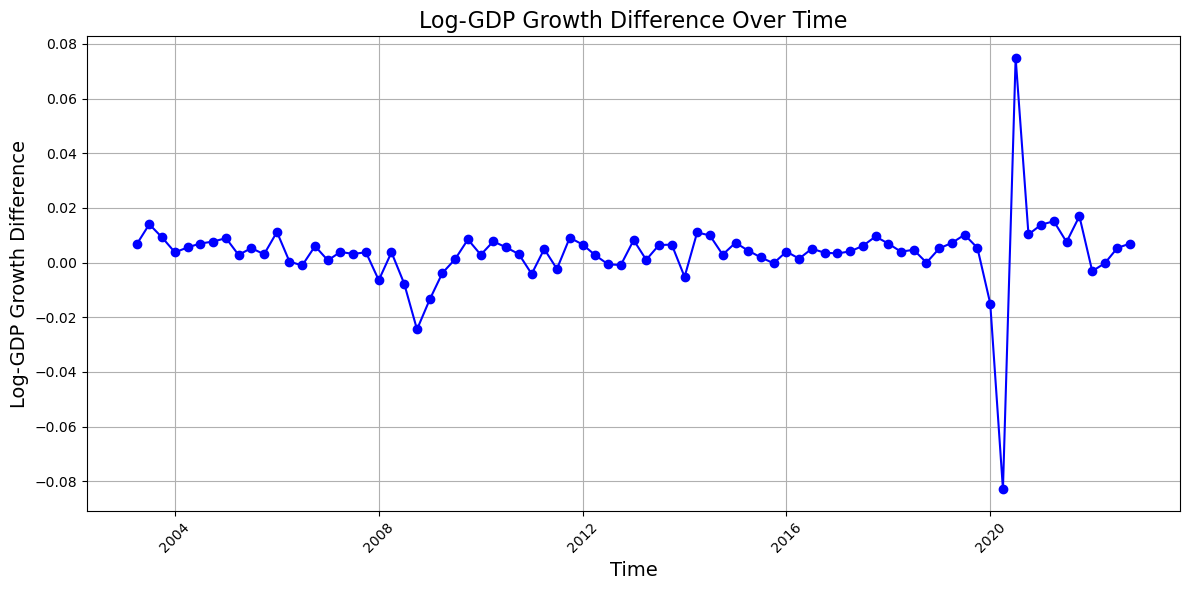

In [49]:
# Plot the Log_GDP_diff time series
plt.figure(figsize=(12, 6))
plt.plot(gdp_df['time'], gdp_df['Log_GDP_diff'], marker='o', linestyle='-', color='blue')

# Customize the plot
plt.title("Log-GDP Growth Difference Over Time", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Log-GDP Growth Difference", fontsize=14)
plt.grid(True)  # Add grid lines for better readability
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Show the plot
plt.tight_layout()  # Ensure the layout fits well
plt.show()


In [11]:
# Log-transform ['dust_pm25', 'dust_pm10', 'dust_aod', 'pm25', 'pm10']
dust_pm25_log = xr.apply_ufunc(np.log, dust_pm25, dask="allowed")
dust_pm10_log = xr.apply_ufunc(np.log, dust_pm10, dask="allowed")
dust_aod_log = xr.apply_ufunc(np.log, dust_aod, dask="allowed")
pm25_log = xr.apply_ufunc(np.log, pm25, dask="allowed")
pm10_log = xr.apply_ufunc(np.log, pm10, dask="allowed")

In [12]:
log_transformed_variables = {
    'dust_pm25_log': dust_pm25_log,
    'dust_pm10_log': dust_pm10_log,
    'dust_aod_log': dust_aod_log,
    'pm25_log': pm25_log,
    'pm10_log': pm10_log
}

In [13]:
# Adjust start and end time to ensure valid overlap
start_time = max(pd.Timestamp(gdp_df['time'].min()), pd.Timestamp(dust_pm25_log.time.min().values))
end_time = min(pd.Timestamp(gdp_df['time'].max()), pd.Timestamp(dust_pm25_log.time.max().values))

print("Adjusted Aligned Time Range:", start_time, "to", end_time)

# Align variables to the overlapping time range
aligned_variables = {}
for var, data in log_transformed_variables.items():
    aligned_variables[var] = data.sel(time=slice(start_time, end_time)).dropna(dim="time", how="any")
    print(f"{var} aligned shape: {aligned_variables[var].shape}, time range: "
          f"{aligned_variables[var].time.min().values} to {aligned_variables[var].time.max().values}")

# Ensure no empty variables after alignment
for var, data in aligned_variables.items():
    if data.time.size == 0:
        raise ValueError(f"{var} is empty after alignment. Check time ranges!")

# Verify consistency of time steps across variables
time_lengths = {var: data.time.size for var, data in aligned_variables.items()}
print("Aligned time lengths:", time_lengths)

# Align GDP data to the same time range
gdp_df = gdp_df[(gdp_df['time'] >= start_time) & (gdp_df['time'] <= end_time)]

# Check for NaN values in GDP data
if gdp_df.isnull().any().any():
    print("Warning: NaN values detected in GDP DataFrame after alignment!")

print("Aligned GDP DataFrame shape:", gdp_df.shape)

Adjusted Aligned Time Range: 2003-04-01 00:00:00 to 2022-10-01 00:00:00
dust_pm25_log aligned shape: (78, 1800, 3600), time range: 2003-06-30T00:00:00.000000000 to 2022-09-30T00:00:00.000000000
dust_pm10_log aligned shape: (78, 1800, 3600), time range: 2003-06-30T00:00:00.000000000 to 2022-09-30T00:00:00.000000000
dust_aod_log aligned shape: (78, 1800, 3600), time range: 2003-06-30T00:00:00.000000000 to 2022-09-30T00:00:00.000000000
pm25_log aligned shape: (78, 1800, 3600), time range: 2003-06-30T00:00:00.000000000 to 2022-09-30T00:00:00.000000000
pm10_log aligned shape: (78, 1800, 3600), time range: 2003-06-30T00:00:00.000000000 to 2022-09-30T00:00:00.000000000
Aligned time lengths: {'dust_pm25_log': 78, 'dust_pm10_log': 78, 'dust_aod_log': 78, 'pm25_log': 78, 'pm10_log': 78}
Aligned GDP DataFrame shape: (79, 4)


In [14]:
# Align GDP times to quarter-end to match pollution variable timestamps
gdp_df['time'] = gdp_df['time'] + pd.offsets.QuarterEnd()
print("Adjusted GDP DataFrame times to quarter-end:\n", gdp_df['time'].head())

Adjusted GDP DataFrame times to quarter-end:
 0   2003-06-30
1   2003-09-30
2   2003-12-31
3   2004-03-31
4   2004-06-30
Name: time, dtype: datetime64[ns]


In [15]:
# Align GDP times to quarter-end to match pollution variable timestamps
gdp_df['time'] = gdp_df['time'] + pd.offsets.QuarterEnd()
print("Adjusted GDP DataFrame times to quarter-end:\n", gdp_df['time'].head())

Adjusted GDP DataFrame times to quarter-end:
 0   2003-09-30
1   2003-12-31
2   2004-03-31
3   2004-06-30
4   2004-09-30
Name: time, dtype: datetime64[ns]


In [16]:
# Verify the time ranges again after adjustment
print("GDP DataFrame time range:", gdp_df['time'].min(), "to", gdp_df['time'].max())
for var, data in aligned_variables.items():
    print(f"{var} time range:", data.time.min().values, "to", data.time.max().values)

GDP DataFrame time range: 2003-09-30 00:00:00 to 2023-03-31 00:00:00
dust_pm25_log time range: 2003-06-30T00:00:00.000000000 to 2022-09-30T00:00:00.000000000
dust_pm10_log time range: 2003-06-30T00:00:00.000000000 to 2022-09-30T00:00:00.000000000
dust_aod_log time range: 2003-06-30T00:00:00.000000000 to 2022-09-30T00:00:00.000000000
pm25_log time range: 2003-06-30T00:00:00.000000000 to 2022-09-30T00:00:00.000000000
pm10_log time range: 2003-06-30T00:00:00.000000000 to 2022-09-30T00:00:00.000000000


In [17]:
# Merge aligned variables with GDP data
merged_variables = {}
for var, data in aligned_variables.items():
    # Aggregate pollution variables over 'lat' and 'lon' dimensions
    variable_df = data.mean(dim=['lat', 'lon']).to_dataframe(name=var).reset_index()
    
    # Drop rows with NaN values (optional)
    variable_df = variable_df.dropna()
    
    # Merge with adjusted GDP data on 'time'
    temp_merged = pd.merge(
        variable_df, 
        gdp_df[['time', 'Log_GDP_diff']], 
        on='time', 
        how='inner'
    )
    
    # Check if merged data is empty
    if temp_merged.empty:
        print(f"Warning: Merged DataFrame for {var} is empty. Check time alignment!")
    else:
        print(f"Merged {var} DataFrame shape after merging:", temp_merged.shape)
    
    merged_variables[var] = temp_merged

Merged dust_pm25_log DataFrame shape after merging: (77, 3)
Merged dust_pm10_log DataFrame shape after merging: (77, 3)
Merged dust_aod_log DataFrame shape after merging: (77, 3)
Merged pm25_log DataFrame shape after merging: (77, 3)
Merged pm10_log DataFrame shape after merging: (77, 3)


In [18]:
# Group the merged data by quarter and calculate means
summary_dataframes = {}
for var, merged_df in merged_variables.items():
    if not merged_df.empty:
        # Ensure 'time' is datetime
        merged_df['time'] = pd.to_datetime(merged_df['time'])
        
        # Group by time and calculate the mean
        summary_dataframes[var] = (
            merged_df.groupby('time')
            .mean()
            .reset_index()
        )
        print(f"Summary DataFrame for {var}: {summary_dataframes[var].shape}")
    else:
        print(f"Skipping {var} as merged data is empty.")

Summary DataFrame for dust_pm25_log: (77, 3)
Summary DataFrame for dust_pm10_log: (77, 3)
Summary DataFrame for dust_aod_log: (77, 3)
Summary DataFrame for pm25_log: (77, 3)
Summary DataFrame for pm10_log: (77, 3)


Regression Summary for dust_pm25_log:
                            OLS Regression Results                            
Dep. Variable:          dust_pm25_log   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.2230
Date:                Mon, 25 Nov 2024   Prob (F-statistic):              0.638
Time:                        20:11:56   Log-Likelihood:                 20.699
No. Observations:                  77   AIC:                            -37.40
Df Residuals:                      75   BIC:                            -32.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const     

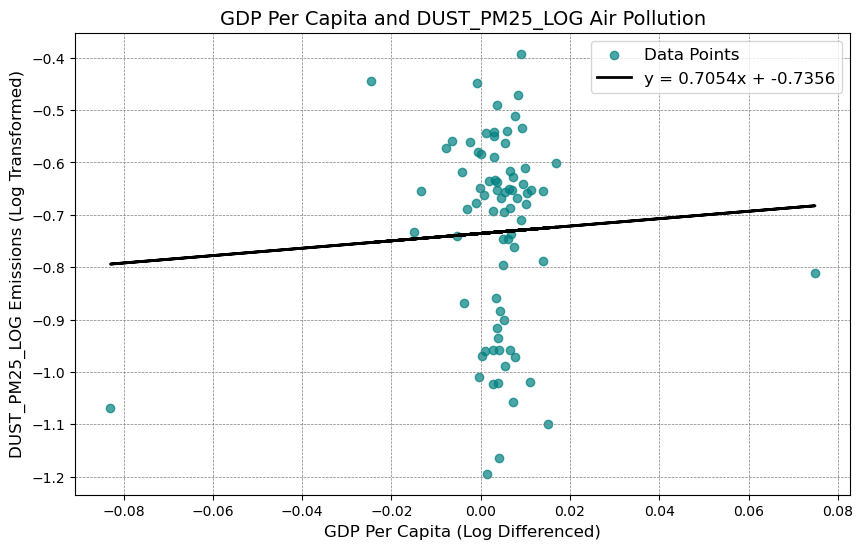

Regression Summary for dust_pm10_log:
                            OLS Regression Results                            
Dep. Variable:          dust_pm10_log   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.2121
Date:                Mon, 25 Nov 2024   Prob (F-statistic):              0.646
Time:                        20:11:56   Log-Likelihood:                 14.251
No. Observations:                  77   AIC:                            -24.50
Df Residuals:                      75   BIC:                            -19.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const     

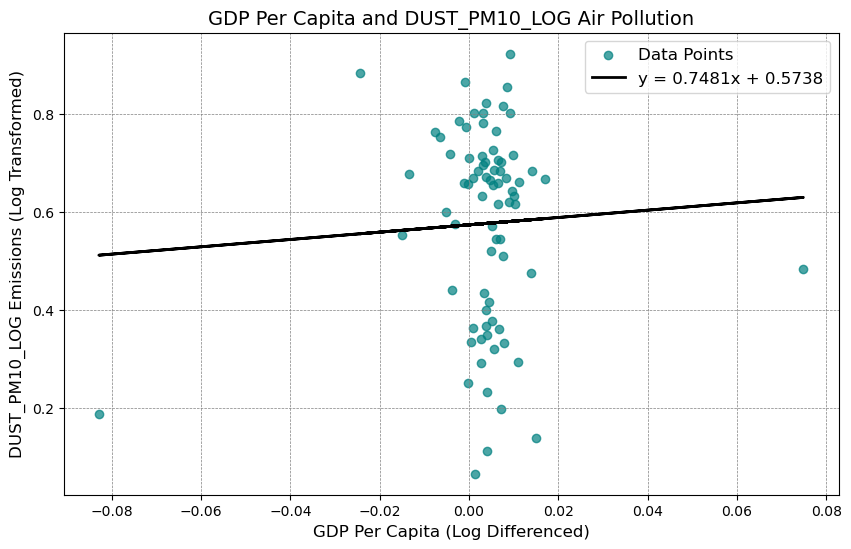

Regression Summary for dust_aod_log:
                            OLS Regression Results                            
Dep. Variable:           dust_aod_log   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.3242
Date:                Mon, 25 Nov 2024   Prob (F-statistic):              0.571
Time:                        20:11:56   Log-Likelihood:                 6.3956
No. Observations:                  77   AIC:                            -8.791
Df Residuals:                      75   BIC:                            -4.104
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const      

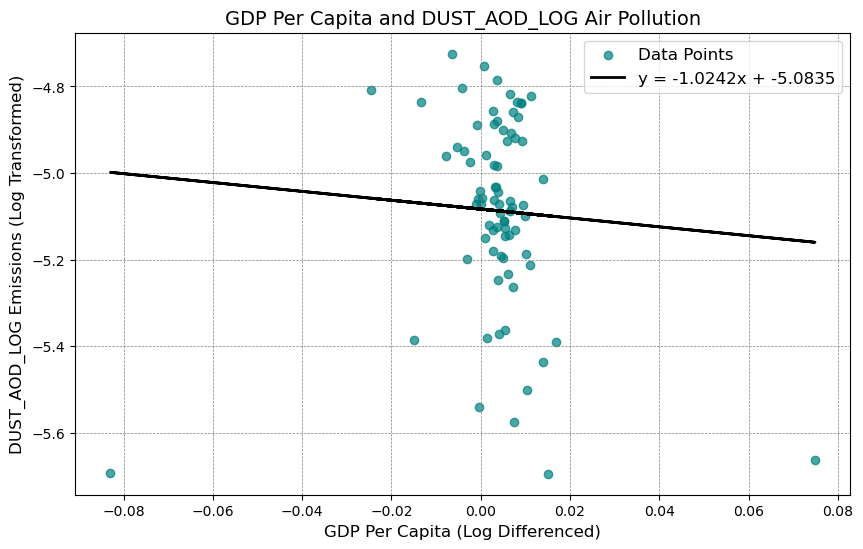

Regression Summary for pm25_log:
                            OLS Regression Results                            
Dep. Variable:               pm25_log   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.4579
Date:                Mon, 25 Nov 2024   Prob (F-statistic):              0.501
Time:                        20:11:56   Log-Likelihood:                 120.22
No. Observations:                  77   AIC:                            -236.4
Df Residuals:                      75   BIC:                            -231.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          

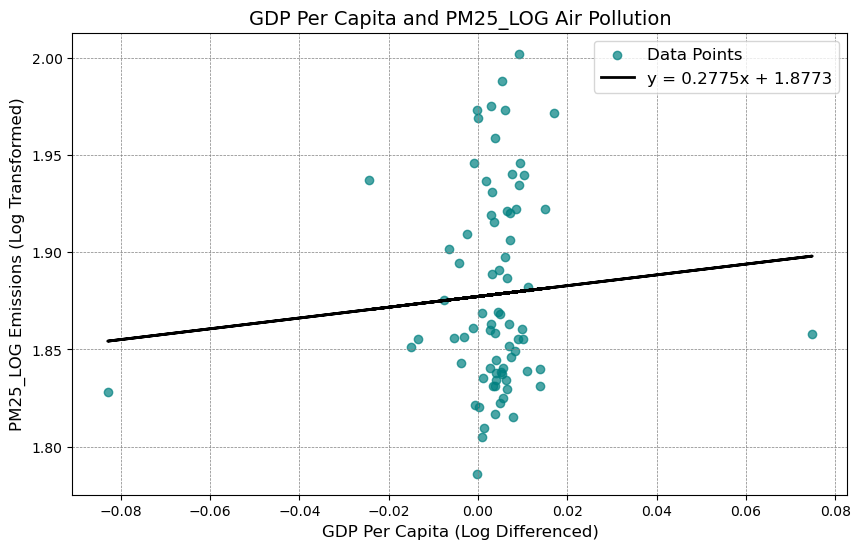

Regression Summary for pm10_log:
                            OLS Regression Results                            
Dep. Variable:               pm10_log   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.081
Date:                Mon, 25 Nov 2024   Prob (F-statistic):              0.302
Time:                        20:11:57   Log-Likelihood:                 98.516
No. Observations:                  77   AIC:                            -193.0
Df Residuals:                      75   BIC:                            -188.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          

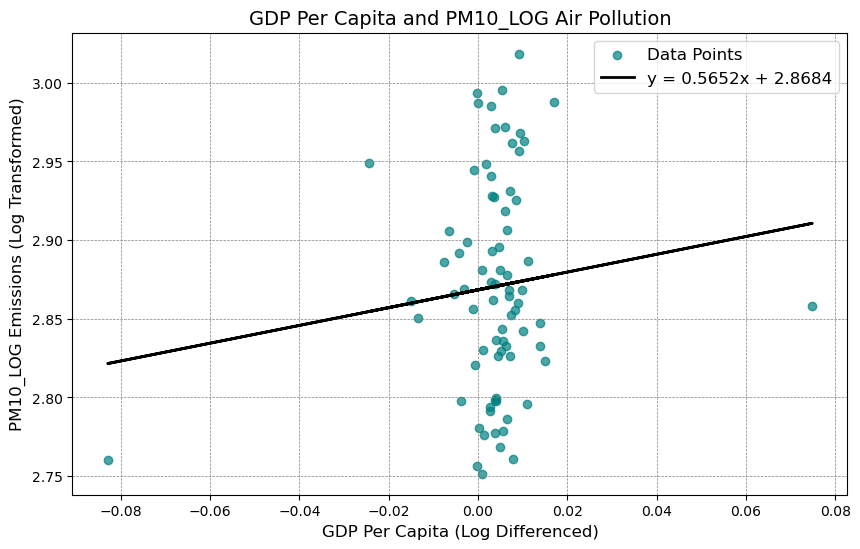

In [20]:
# Run regressions for each pollution variable and plot results
for var, summary_df in summary_dataframes.items():
    # Skip empty DataFrames
    if summary_df.empty:
        print(f"Skipping regression for {var} due to empty DataFrame.")
        continue
    
    # Check for missing values
    if summary_df['Log_GDP_diff'].isna().any() or summary_df[var].isna().any():
        print(f"Skipping regression for {var} due to missing data.")
        continue
    
    # Add a constant for the regression model
    X = sm.add_constant(summary_df['Log_GDP_diff'])  # Predictor
    y = summary_df[var]  # Response variable
    
    # Perform linear regression
    model = sm.OLS(y, X).fit()
    
    # Print regression summary
    print(f"Regression Summary for {var}:")
    print(model.summary())
    
    # Plot the regression line with confidence intervals
    plt.figure(figsize=(10, 6))
    plt.scatter(summary_df['Log_GDP_diff'], y, alpha=0.7, label='Data Points', color='teal')
    
    # Add regression line with updated index access
    plt.plot(summary_df['Log_GDP_diff'], model.predict(X), color='black', linewidth=2, 
             label=f"y = {model.params.iloc[1]:.4f}x + {model.params.iloc[0]:.4f}")

    # Add labels, title, and legend
    plt.title(f'GDP Per Capita and {var.upper()} Air Pollution', fontsize=14)
    plt.xlabel('GDP Per Capita (Log Differenced)', fontsize=12)
    plt.ylabel(f'{var.upper()} Emissions (Log Transformed)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.show()

In [25]:
quarterly_pollution_variables = {
    'dust_pm25_quarterly': dust_pm25_quarterly,
    'dust_pm10_quarterly': dust_pm10_quarterly,
    'dust_aod_quarterly': dust_aod_quarterly,
    'pm25_quarterly': pm25_quarterly,
    'pm10_quarterly': pm10_quarterly,
}

In [26]:
# Adjust start and end time to ensure valid overlap
start_time = max(pd.Timestamp(gdp_df['time'].min()), pd.Timestamp(dust_pm25_quarterly.time.min().values))
end_time = min(pd.Timestamp(gdp_df['time'].max()), pd.Timestamp(dust_pm25_quarterly.time.max().values))

print("Adjusted Aligned Time Range:", start_time, "to", end_time)

# Align variables to the overlapping time range
aligned_quarterly_variables = {}
for var, data in quarterly_pollution_variables.items():
    aligned_quarterly_variables[var] = data.sel(time=slice(start_time, end_time)).dropna(dim="time", how="any")
    print(f"{var} aligned shape: {aligned_quarterly_variables[var].shape}, time range: "
          f"{aligned_quarterly_variables[var].time.min().values} to {aligned_quarterly_variables[var].time.max().values}")

# Ensure no empty variables after alignment
for var, data in aligned_quarterly_variables.items():
    if data.time.size == 0:
        raise ValueError(f"{var} is empty after alignment. Check time ranges!")

# Verify consistency of time steps across variables
time_lengths = {var: data.time.size for var, data in aligned_quarterly_variables.items()}
print("Aligned time lengths:", time_lengths)

# Align GDP data to the same time range
gdp_df = gdp_df[(gdp_df['time'] >= start_time) & (gdp_df['time'] <= end_time)]

# Check for NaN values in GDP data
if gdp_df.isnull().any().any():
    print("Warning: NaN values detected in GDP DataFrame after alignment!")

print("Aligned GDP DataFrame shape:", gdp_df.shape)


Adjusted Aligned Time Range: 2003-09-30 00:00:00 to 2022-12-31 00:00:00
dust_pm25_quarterly aligned shape: (78, 1800, 3600), time range: 2003-09-30T00:00:00.000000000 to 2022-12-31T00:00:00.000000000
dust_pm10_quarterly aligned shape: (78, 1800, 3600), time range: 2003-09-30T00:00:00.000000000 to 2022-12-31T00:00:00.000000000
dust_aod_quarterly aligned shape: (78, 1800, 3600), time range: 2003-09-30T00:00:00.000000000 to 2022-12-31T00:00:00.000000000
pm25_quarterly aligned shape: (78, 1800, 3600), time range: 2003-09-30T00:00:00.000000000 to 2022-12-31T00:00:00.000000000
pm10_quarterly aligned shape: (78, 1800, 3600), time range: 2003-09-30T00:00:00.000000000 to 2022-12-31T00:00:00.000000000
Aligned time lengths: {'dust_pm25_quarterly': 78, 'dust_pm10_quarterly': 78, 'dust_aod_quarterly': 78, 'pm25_quarterly': 78, 'pm10_quarterly': 78}
Aligned GDP DataFrame shape: (78, 4)


In [28]:
# Align GDP times to quarter-end to match pollution variable timestamps
gdp_df['time'] = gdp_df['time'] + pd.offsets.QuarterEnd()
print("Adjusted GDP DataFrame times to quarter-end:\n", gdp_df['time'].head())

# Verify the time ranges again after adjustment
print("GDP DataFrame time range:", gdp_df['time'].min(), "to", gdp_df['time'].max())
for var, data in aligned_quarterly_variables.items():
    print(f"{var} time range:", data.time.min().values, "to", data.time.max().values)

Adjusted GDP DataFrame times to quarter-end:
 0   2003-12-31
1   2004-03-31
2   2004-06-30
3   2004-09-30
4   2004-12-31
Name: time, dtype: datetime64[ns]
GDP DataFrame time range: 2003-12-31 00:00:00 to 2023-03-31 00:00:00
dust_pm25_quarterly time range: 2003-09-30T00:00:00.000000000 to 2022-12-31T00:00:00.000000000
dust_pm10_quarterly time range: 2003-09-30T00:00:00.000000000 to 2022-12-31T00:00:00.000000000
dust_aod_quarterly time range: 2003-09-30T00:00:00.000000000 to 2022-12-31T00:00:00.000000000
pm25_quarterly time range: 2003-09-30T00:00:00.000000000 to 2022-12-31T00:00:00.000000000
pm10_quarterly time range: 2003-09-30T00:00:00.000000000 to 2022-12-31T00:00:00.000000000


In [31]:
# Calculate GDP differences
gdp_df['GDP_diff'] = gdp_df['GDP'].diff()

# Drop the first row which will have NaN after differencing
gdp_df = gdp_df.dropna(subset=['GDP_diff']).reset_index(drop=True)

In [32]:
# Convert 'time' columns to datetime
gdp_df['time'] = pd.to_datetime(gdp_df['time'])
variable_df['time'] = pd.to_datetime(variable_df['time'])

In [33]:
# Find overlapping time range
start_time = max(gdp_df['time'].min(), variable_df['time'].min())
end_time = min(gdp_df['time'].max(), variable_df['time'].max())

# Filter data within the overlapping time range
gdp_df = gdp_df[(gdp_df['time'] >= start_time) & (gdp_df['time'] <= end_time)].reset_index(drop=True)
variable_df = variable_df[(variable_df['time'] >= start_time) & (variable_df['time'] <= end_time)].reset_index(drop=True)

In [34]:
print("GDP times:\n", gdp_df['time'].head())
print(f"{var} times:\n", variable_df['time'].head())

GDP times:
 0   2004-03-31
1   2004-06-30
2   2004-09-30
3   2004-12-31
4   2005-03-31
Name: time, dtype: datetime64[ns]
dust_pm25_quarterly times:
 0   2004-03-31
1   2004-06-30
2   2004-09-30
3   2004-12-31
4   2005-03-31
Name: time, dtype: datetime64[ns]


In [35]:
# Merge with adjusted GDP data on 'time'
temp_merged = pd.merge(
    variable_df,
    gdp_df[['time', 'GDP_diff']],
    on='time',
    how='inner'
)

In [36]:
if temp_merged.empty:
    print(f"Warning: Merged DataFrame for {var} is empty after merging. Check time alignment and data availability.")
else:
    print(f"Merged {var} DataFrame shape after merging:", temp_merged.shape)

Merged dust_pm25_quarterly DataFrame shape after merging: (76, 3)


In [37]:
# Ensure GDP_diff exists in gdp_df
if 'GDP_diff' not in gdp_df.columns:
    # Calculate GDP differences
    gdp_df['GDP_diff'] = gdp_df['GDP'].diff()
    # Drop NaNs resulting from differencing
    gdp_df = gdp_df.dropna(subset=['GDP_diff']).reset_index(drop=True)

# Convert 'time' columns to datetime
gdp_df['time'] = pd.to_datetime(gdp_df['time'])

merged_quarterly_variables = {}

for var, data in aligned_quarterly_variables.items():
    # Aggregate pollution variables over 'lat' and 'lon' dimensions
    variable_df = data.mean(dim=['lat', 'lon']).to_dataframe(name=var).reset_index()

    # Drop rows with NaN values (optional)
    variable_df = variable_df.dropna()

    # Convert 'time' column to datetime
    variable_df['time'] = pd.to_datetime(variable_df['time'])

    # Align time ranges between gdp_df and variable_df
    start_time = max(gdp_df['time'].min(), variable_df['time'].min())
    end_time = min(gdp_df['time'].max(), variable_df['time'].max())

    # Filter data within the overlapping time range
    gdp_df_filtered = gdp_df[(gdp_df['time'] >= start_time) & (gdp_df['time'] <= end_time)].reset_index(drop=True)
    variable_df_filtered = variable_df[(variable_df['time'] >= start_time) & (variable_df['time'] <= end_time)].reset_index(drop=True)

    # Merge with adjusted GDP data on 'time'
    temp_merged = pd.merge(
        variable_df_filtered,
        gdp_df_filtered[['time', 'GDP_diff']],
        on='time',
        how='inner'
    )

    # Check if merged data is empty
    if temp_merged.empty:
        print(f"Warning: Merged DataFrame for {var} is empty after merging. Check time alignment and data availability.")
        # Optionally, print time ranges for debugging
        print(f"{var} time range: {variable_df_filtered['time'].min()} to {variable_df_filtered['time'].max()}")
        print(f"GDP time range: {gdp_df_filtered['time'].min()} to {gdp_df_filtered['time'].max()}")
    else:
        print(f"Merged {var} DataFrame shape after merging:", temp_merged.shape)

    merged_quarterly_variables[var] = temp_merged

Merged dust_pm25_quarterly DataFrame shape after merging: (76, 3)
Merged dust_pm10_quarterly DataFrame shape after merging: (76, 3)
Merged dust_aod_quarterly DataFrame shape after merging: (76, 3)
Merged pm25_quarterly DataFrame shape after merging: (76, 3)
Merged pm10_quarterly DataFrame shape after merging: (76, 3)


Regression Summary for dust_pm25_quarterly:
                             OLS Regression Results                            
Dep. Variable:     dust_pm25_quarterly   R-squared:                       0.062
Model:                             OLS   Adj. R-squared:                  0.049
Method:                  Least Squares   F-statistic:                     4.894
Date:                 Mon, 25 Nov 2024   Prob (F-statistic):             0.0300
Time:                         20:48:49   Log-Likelihood:                -49.509
No. Observations:                   76   AIC:                             103.0
Df Residuals:                       74   BIC:                             107.7
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

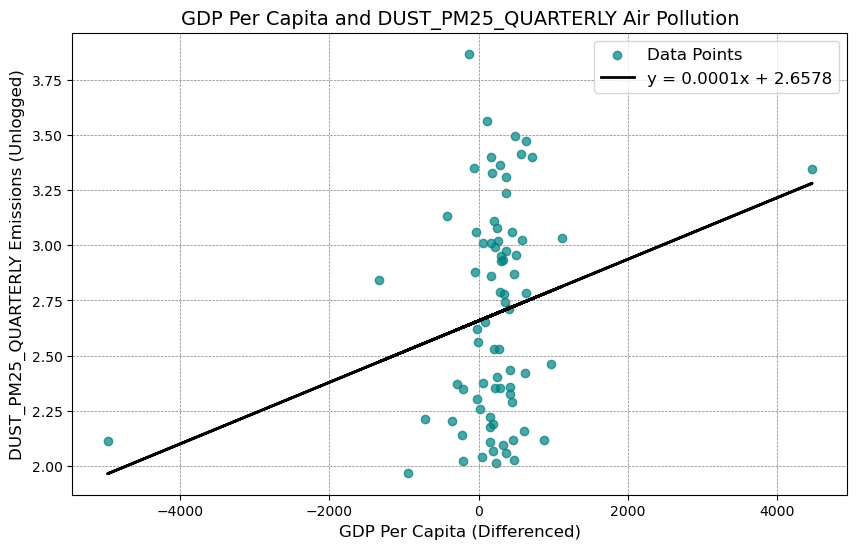

Regression Summary for dust_pm10_quarterly:
                             OLS Regression Results                            
Dep. Variable:     dust_pm10_quarterly   R-squared:                       0.058
Model:                             OLS   Adj. R-squared:                  0.046
Method:                  Least Squares   F-statistic:                     4.583
Date:                 Mon, 25 Nov 2024   Prob (F-statistic):             0.0356
Time:                         20:48:49   Log-Likelihood:                -146.70
No. Observations:                   76   AIC:                             297.4
Df Residuals:                       74   BIC:                             302.1
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

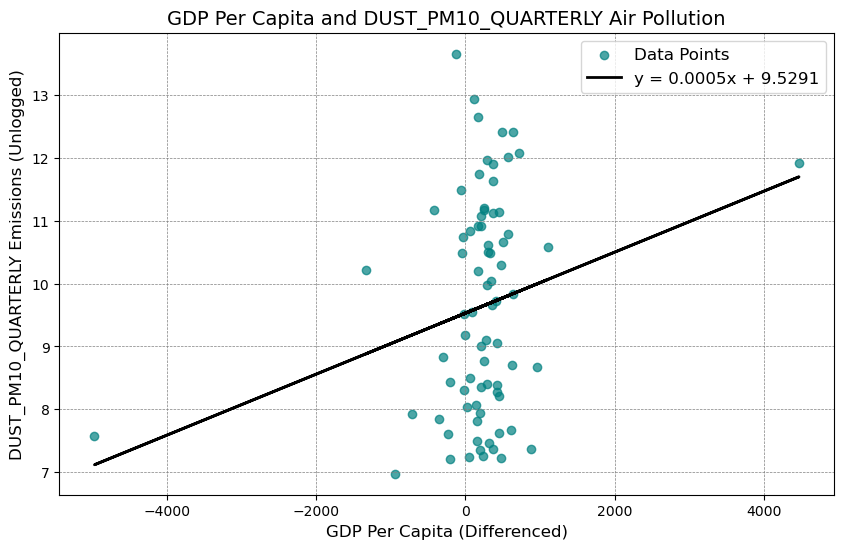

Regression Summary for dust_aod_quarterly:
                            OLS Regression Results                            
Dep. Variable:     dust_aod_quarterly   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.1552
Date:                Mon, 25 Nov 2024   Prob (F-statistic):              0.695
Time:                        20:48:49   Log-Likelihood:                 287.80
No. Observations:                  76   AIC:                            -571.6
Df Residuals:                      74   BIC:                            -566.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

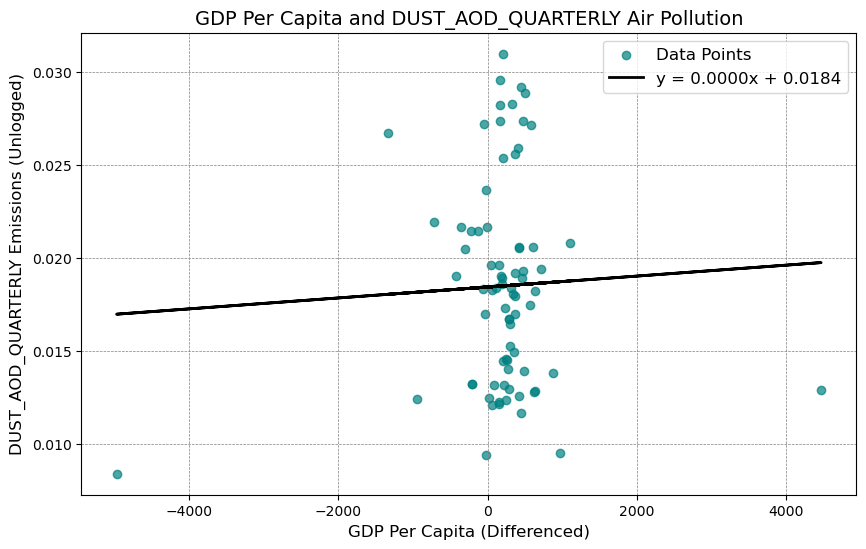

Regression Summary for pm25_quarterly:
                            OLS Regression Results                            
Dep. Variable:         pm25_quarterly   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     5.586
Date:                Mon, 25 Nov 2024   Prob (F-statistic):             0.0207
Time:                        20:48:49   Log-Likelihood:                -56.458
No. Observations:                  76   AIC:                             116.9
Df Residuals:                      74   BIC:                             121.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

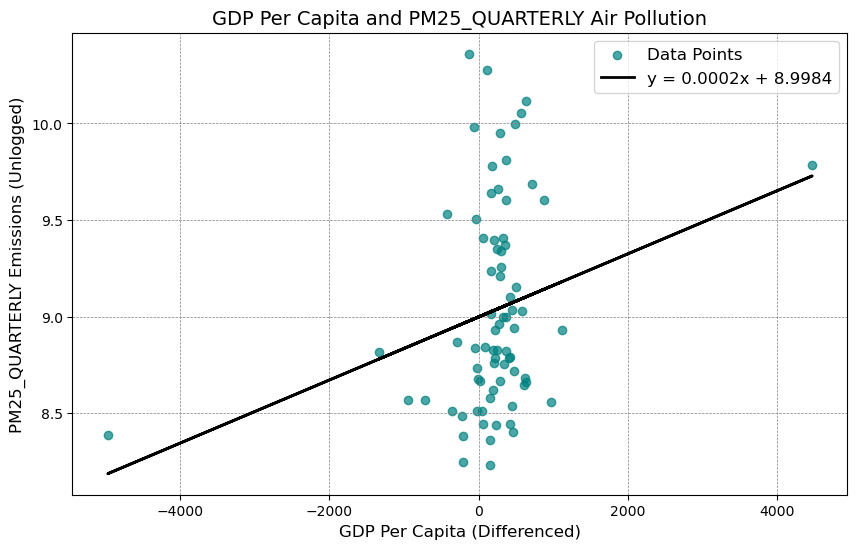

Regression Summary for pm10_quarterly:
                            OLS Regression Results                            
Dep. Variable:         pm10_quarterly   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     4.719
Date:                Mon, 25 Nov 2024   Prob (F-statistic):             0.0330
Time:                        20:48:49   Log-Likelihood:                -152.45
No. Observations:                  76   AIC:                             308.9
Df Residuals:                      74   BIC:                             313.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

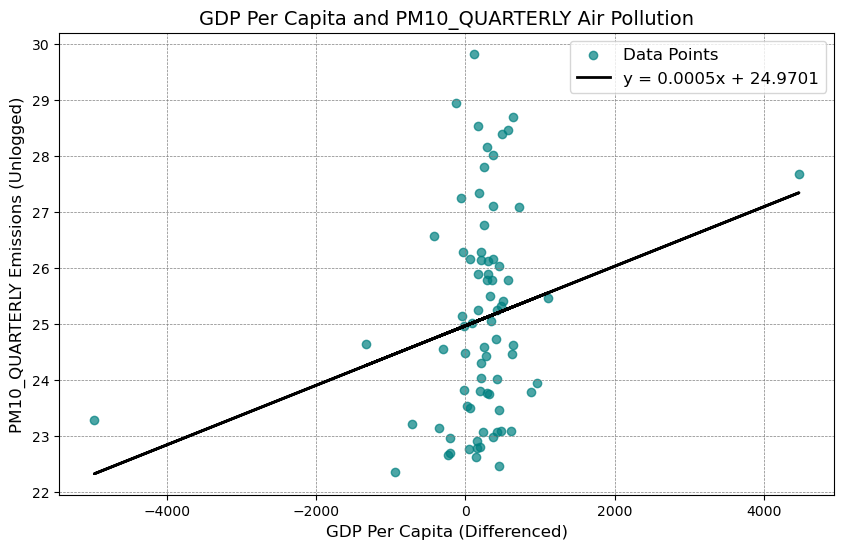

In [39]:
# Run regressions for each pollution variable and plot results
for var, merged_df in merged_quarterly_variables.items():
    # Skip empty DataFrames
    if merged_df.empty:
        print(f"Skipping regression for {var} due to empty DataFrame.")
        continue
    
    # Check for missing values in GDP_diff or the pollution variable
    if merged_df['GDP_diff'].isna().any() or merged_df[var].isna().any():
        print(f"Skipping regression for {var} due to missing data.")
        continue
    
    # Add a constant for the regression model
    X = sm.add_constant(merged_df['GDP_diff'])  # Predictor: GDP_diff
    y = merged_df[var]  # Response variable: pollution variable (unlogged)
    
    # Perform linear regression
    model = sm.OLS(y, X).fit()
    
    # Print regression summary
    print(f"Regression Summary for {var}:")
    print(model.summary())
    
    # Plot the regression line with scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(merged_df['GDP_diff'], y, alpha=0.7, label='Data Points', color='teal')
    
    # Add regression line using .iloc to access coefficients
    plt.plot(merged_df['GDP_diff'], model.predict(X), color='black', linewidth=2, 
             label=f"y = {model.params.iloc[1]:.4f}x + {model.params.iloc[0]:.4f}")
    
    # Customize the plot
    plt.title(f'GDP Per Capita and {var.upper()} Air Pollution', fontsize=14)
    plt.xlabel('GDP Per Capita (Differenced)', fontsize=12)
    plt.ylabel(f'{var.upper()} Emissions (Unlogged)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.show()


<p style="font-size:30px;">Composites :</p>

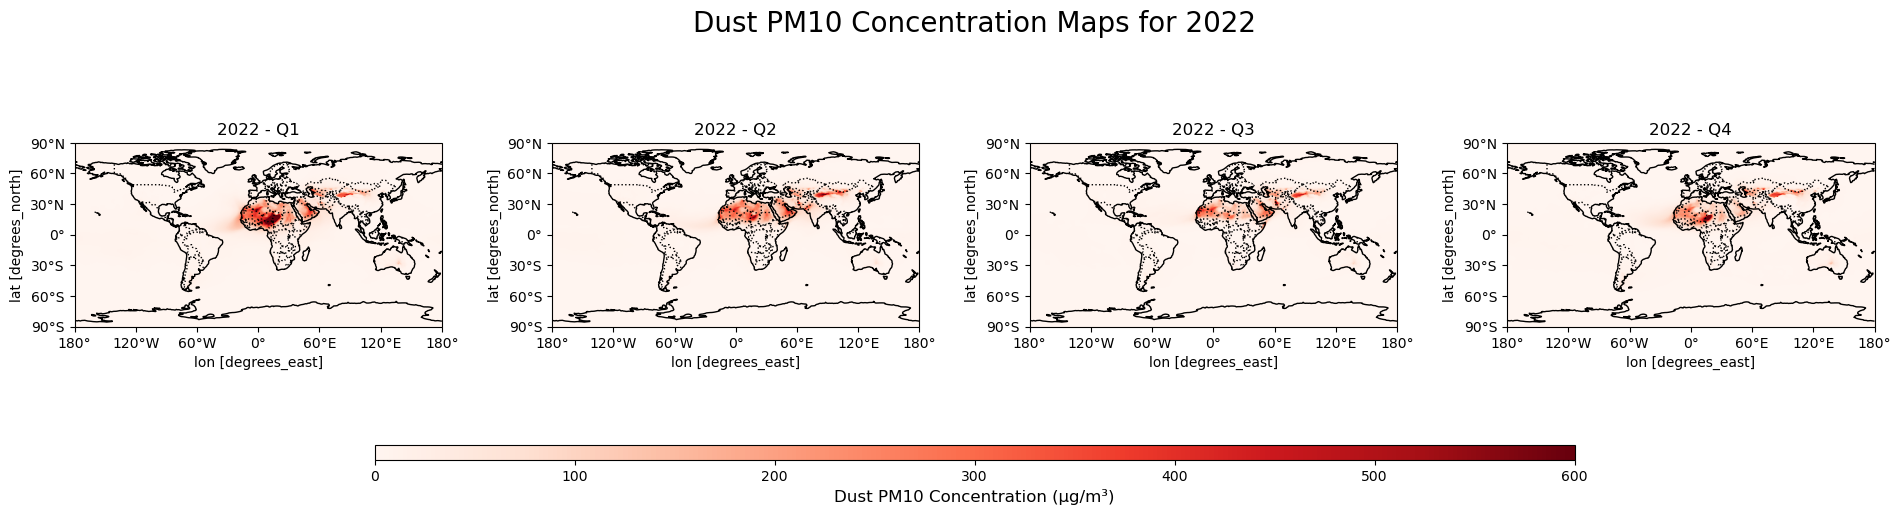

In [5]:
# Extract the last year of data (2022)
last_year = ds_quarterly.time.dt.year.max().values
dust_pm10_last_year = ds_quarterly['dust_pm10'].sel(time=str(last_year))

# Create a figure with subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle(f"Dust PM10 Concentration Maps for {last_year}", fontsize=20, y=0.95)

# Loop through the 4 quarters
for col_idx, quarter in enumerate(range(1, 5)):
    ax = axs[col_idx]
    quarter_data = dust_pm10_last_year.sel(time=dust_pm10_last_year.time.dt.quarter == quarter)
    im = quarter_data.mean(dim='time').plot(
        ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', 
        vmin=0, vmax=600,  # Adjust the color range
        add_colorbar=False, zorder=1
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_title(f"2022 - Q{quarter}", fontsize=12)
    ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
    ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

# Add a single colorbar below all the subplots
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03])  # Adjust position as needed
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Dust PM10 Concentration (µg/m³)", fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Adjust layout manually
fig.subplots_adjust(top=0.85, bottom=0.15, left=0.05, right=0.95, hspace=0.3, wspace=0.3)

plt.show()

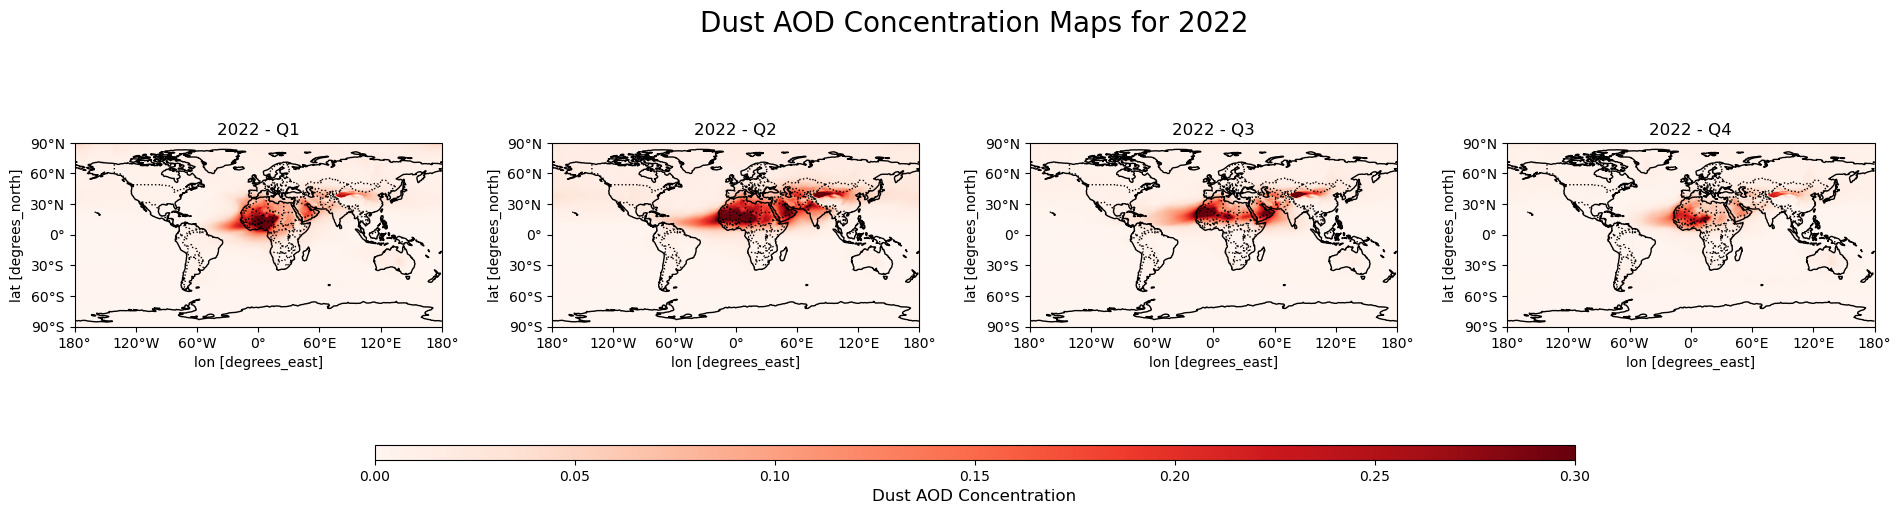

In [48]:
# Extract the last year of data (2022)
last_year = ds_quarterly.time.dt.year.max().values
dust_aod_last_year = ds_quarterly['dust_aod'].sel(time=str(last_year))

# Create a figure with subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle(f"Dust AOD Concentration Maps for {last_year}", fontsize=20, y=0.95)

# Loop through the 4 quarters
for col_idx, quarter in enumerate(range(1, 5)):
    ax = axs[col_idx]
    quarter_data = dust_aod_last_year.sel(time=dust_aod_last_year.time.dt.quarter == quarter)
    im = quarter_data.mean(dim='time').plot(
        ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', 
        vmin=0, vmax=0.3,  # Set the color bar range
        add_colorbar=False, zorder=1
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_title(f"2022 - Q{quarter}", fontsize=12)
    ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
    ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

# Add a single colorbar below all the subplots
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03])  # Adjust position as needed
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Dust AOD Concentration", fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Adjust layout manually
fig.subplots_adjust(top=0.85, bottom=0.15, left=0.05, right=0.95, hspace=0.3, wspace=0.3)

plt.show()


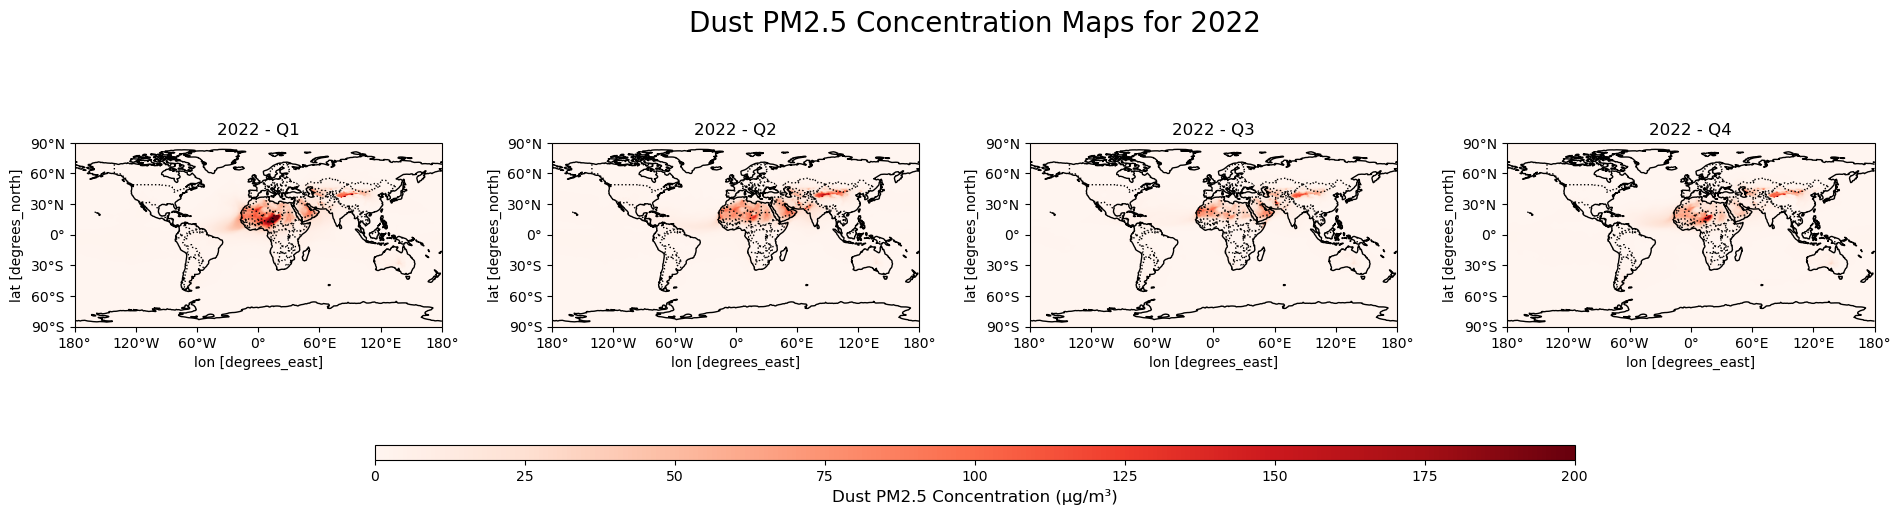

In [49]:
# Extract the last year of data (2022)
last_year = ds_quarterly.time.dt.year.max().values
dust_pm25_last_year = ds_quarterly['dust_pm25'].sel(time=str(last_year))

# Create a figure with subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle(f"Dust PM2.5 Concentration Maps for {last_year}", fontsize=20, y=0.95)

# Loop through the 4 quarters
for col_idx, quarter in enumerate(range(1, 5)):
    ax = axs[col_idx]
    quarter_data = dust_pm25_last_year.sel(time=dust_pm25_last_year.time.dt.quarter == quarter)
    im = quarter_data.mean(dim='time').plot(
        ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', 
        vmin=0, vmax=200,  # Set the color bar range
        add_colorbar=False, zorder=1
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_title(f"2022 - Q{quarter}", fontsize=12)
    ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
    ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

# Add a single colorbar below all the subplots
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03])  # Adjust position as needed
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Dust PM2.5 Concentration (µg/m³)", fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Adjust layout manually
fig.subplots_adjust(top=0.85, bottom=0.15, left=0.05, right=0.95, hspace=0.3, wspace=0.3)

plt.show()


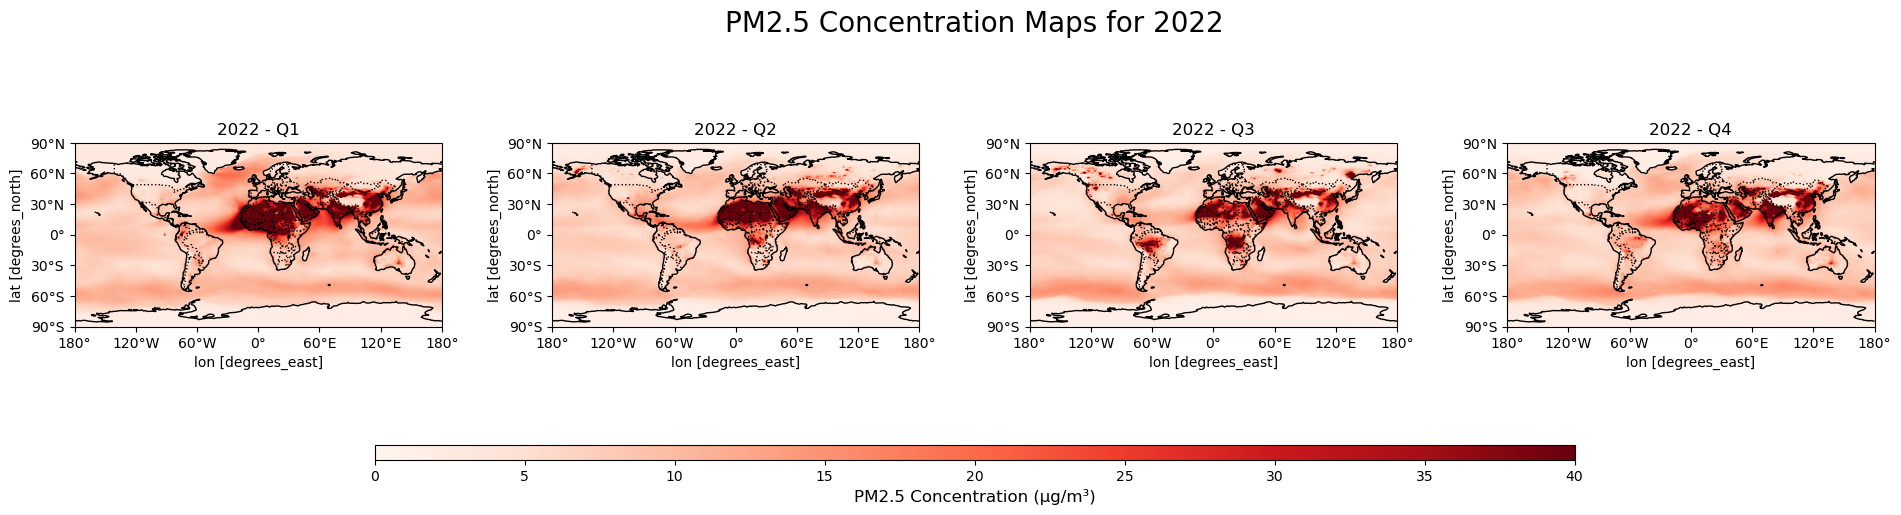

In [50]:
# Extract the last year of data (2022)
last_year = ds_quarterly.time.dt.year.max().values
pm25_last_year = ds_quarterly['pm25'].sel(time=str(last_year))

# Create a figure with subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle(f"PM2.5 Concentration Maps for {last_year}", fontsize=20, y=0.95)

# Loop through the 4 quarters
for col_idx, quarter in enumerate(range(1, 5)):
    ax = axs[col_idx]
    quarter_data = pm25_last_year.sel(time=pm25_last_year.time.dt.quarter == quarter)
    im = quarter_data.mean(dim='time').plot(
        ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', 
        vmin=0, vmax=40,  # Set the color bar range
        add_colorbar=False, zorder=1
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_title(f"2022 - Q{quarter}", fontsize=12)
    ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
    ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

# Add a single colorbar below all the subplots
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03])  # Adjust position as needed
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label("PM2.5 Concentration (µg/m³)", fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Adjust layout manually
fig.subplots_adjust(top=0.85, bottom=0.15, left=0.05, right=0.95, hspace=0.3, wspace=0.3)

plt.show()


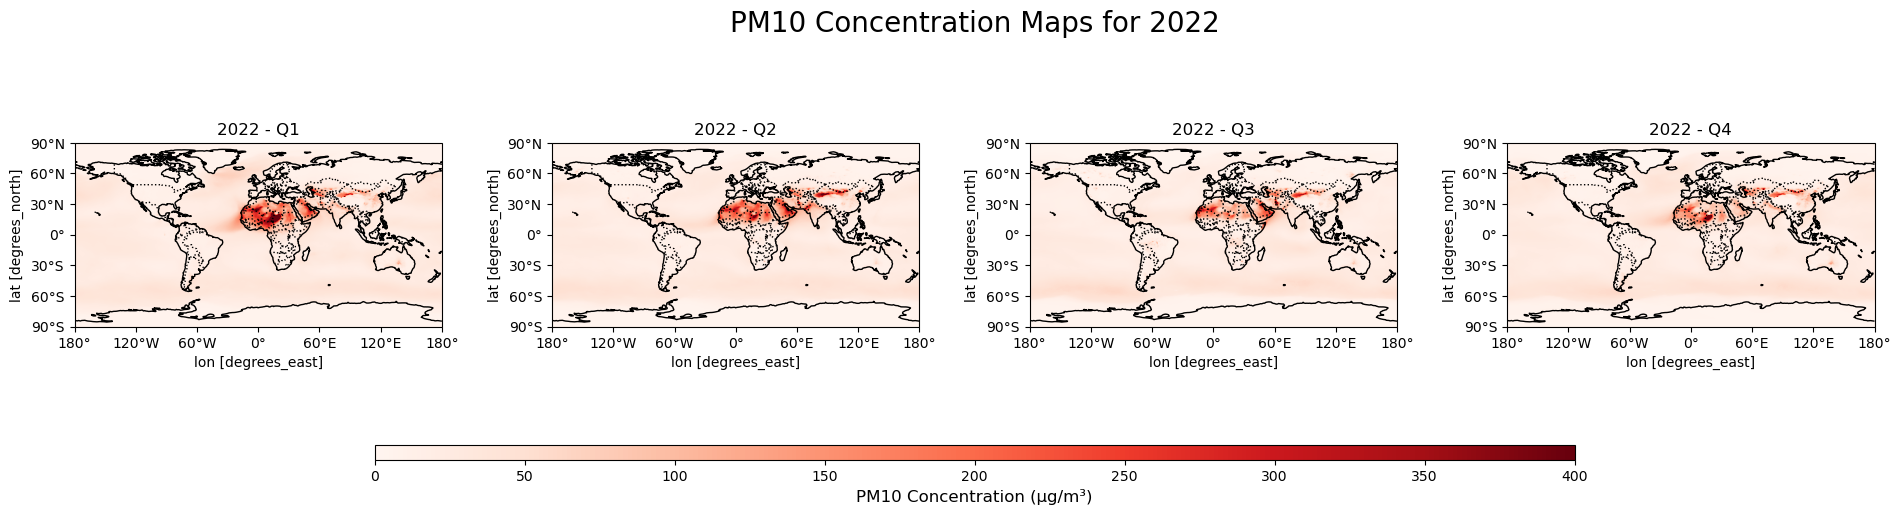

In [51]:
# Extract the last year of data (2022)
last_year = ds_quarterly.time.dt.year.max().values
pm10_last_year = ds_quarterly['pm10'].sel(time=str(last_year))

# Create a figure with subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle(f"PM10 Concentration Maps for {last_year}", fontsize=20, y=0.95)

# Loop through the 4 quarters
for col_idx, quarter in enumerate(range(1, 5)):
    ax = axs[col_idx]
    quarter_data = pm10_last_year.sel(time=pm10_last_year.time.dt.quarter == quarter)
    im = quarter_data.mean(dim='time').plot(
        ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', 
        vmin=0, vmax=400,  # Set the color bar range
        add_colorbar=False, zorder=1
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_title(f"2022 - Q{quarter}", fontsize=12)
    ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(cticker.LongitudeFormatter())
    ax.yaxis.set_major_formatter(cticker.LatitudeFormatter())

# Add a single colorbar below all the subplots
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03])  # Adjust position as needed
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label("PM10 Concentration (µg/m³)", fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Adjust layout manually
fig.subplots_adjust(top=0.85, bottom=0.15, left=0.05, right=0.95, hspace=0.3, wspace=0.3)

plt.show()

Above maps provide a quarterly overview of pollution variables (e.g., DUST_PM25, DUST_PM10, DUST_AOD, PM25, PM10) across 2022.

Higher concentrations of dust-related pollutants are evident over regions like North Africa and the Middle East, which aligns with desert areas prone to dust storms. Variables like DUST_PM25 and DUST_PM10 focus specifically on dust, showing high values over desert regions.

The GDP per capita in the USA might not directly correlate with dust-specific pollutants like DUST_PM25, DUST_PM10, or DUST_AOD, as these maps suggest that the dust concentrations over North America are negligible. 

However, PM25 and PM10 encompass more than just dust. These variables also include other fine particulate matter from sources such as:

- **Urban emissions** (e.g., vehicle exhaust, industrial processes).
- **Agricultural activities** (e.g., ammonia emissions).
- **Wildfires** (e.g., significant sources of PM2.5 in the western USA).
- **Domestic heating** (common during colder months in the USA).

Relevance of GDP in the USA Context:

- **Industrial and Urban Pollution:**
While the USA may not experience dust storms, PM2.5 and PM10 in urban and industrial areas are influenced by economic activity, urbanization, and population density. Higher GDP per capita might correlate with better emission controls or more pollution in some regions.

- **Transport of Dust:**
While negligible in these maps, there can still be occasional long-range transport of Saharan dust to parts of North America, especially during summer. But these events are likely too weak or infrequent to show up in annual or quarterly means.

- **Focus on Domestic Pollutants:**
The USA’s PM2.5 and PM10 concentrations might be more influenced by anthropogenic emissions rather than natural dust. The GDP per capita in the USA could indirectly link to PM concentrations through patterns of energy use, industry, and air quality management policies.

<p style="font-size:30px;">Calculate Anomalies<p/>

In [6]:
# Initialize a dictionary to store anomaly data
anomaly_pollution_vars = {}

# List of pollution variables
pollution_vars = ['dust_pm25', 'dust_pm10', 'dust_aod', 'pm25', 'pm10']

# Calculate anomalies relative to the mean for each quarter
for var in pollution_vars:
    # Access the variable from the loaded dataset
    variable_data = ds_quarterly[var]
    
    # Calculate the quarterly mean across all times (reference mean)
    mean_by_quarter = variable_data.groupby('time.quarter').mean(dim='time')
    
    # Calculate anomalies for each quarter
    anomalies = variable_data.groupby('time.quarter') - mean_by_quarter
    anomaly_pollution_vars[f"anomaly_{var}"] = anomalies

# `anomaly_pollution_vars` now contains anomalies for each variable.

Global dynamic range for DUST_PM25: vmin=-0.654214388132095, vmax=0.5655975401401463


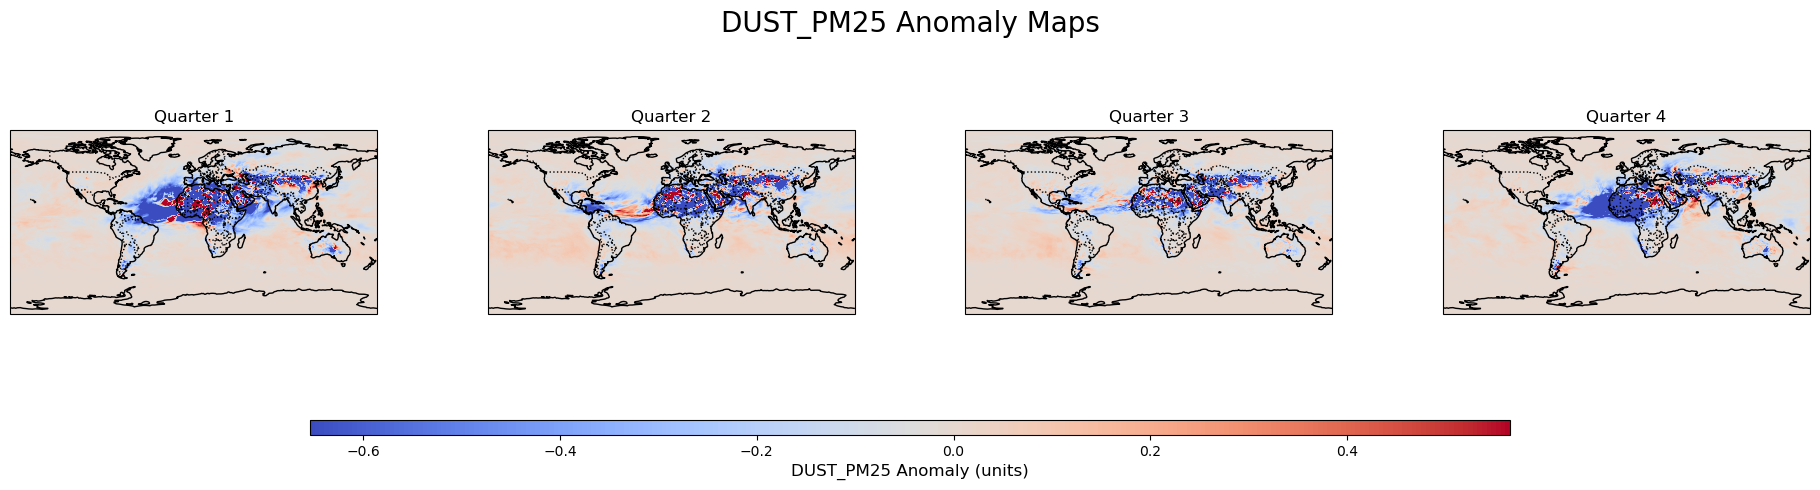

Global dynamic range for DUST_PM10: vmin=-2.191246509552002, vmax=1.8868627548217773


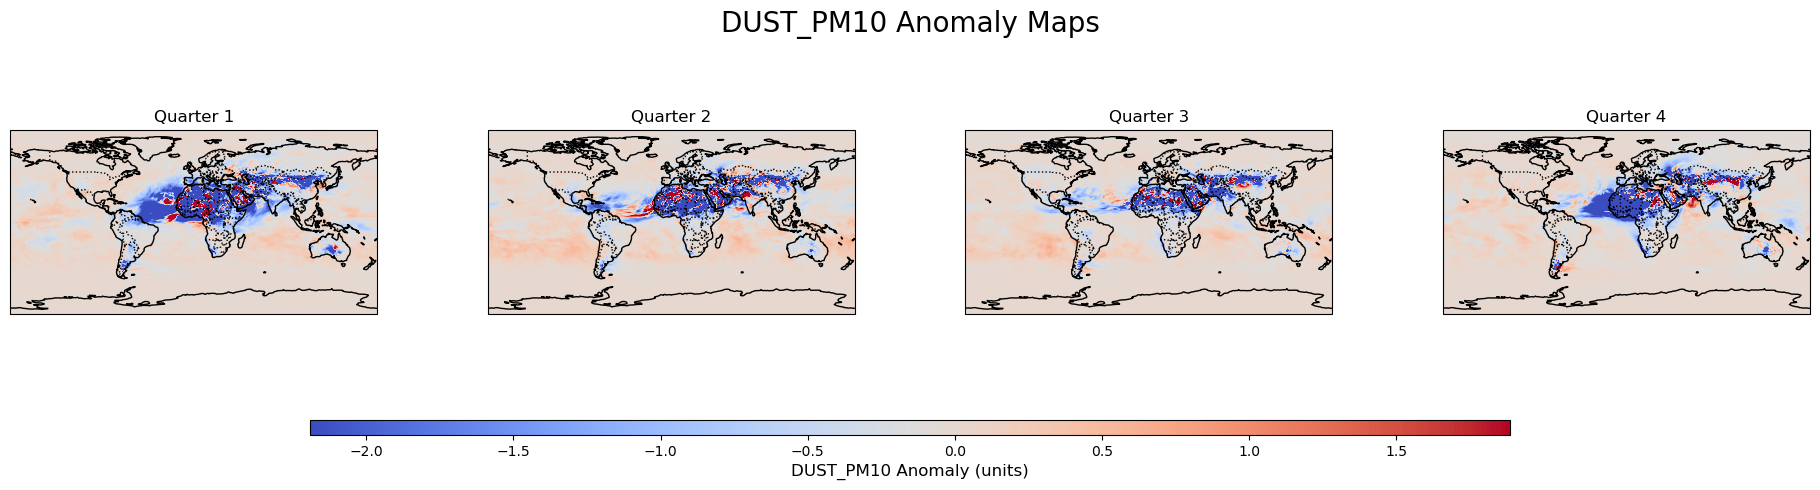

Global dynamic range for DUST_AOD: vmin=-0.0067877923138439655, vmax=0.006310117430984974


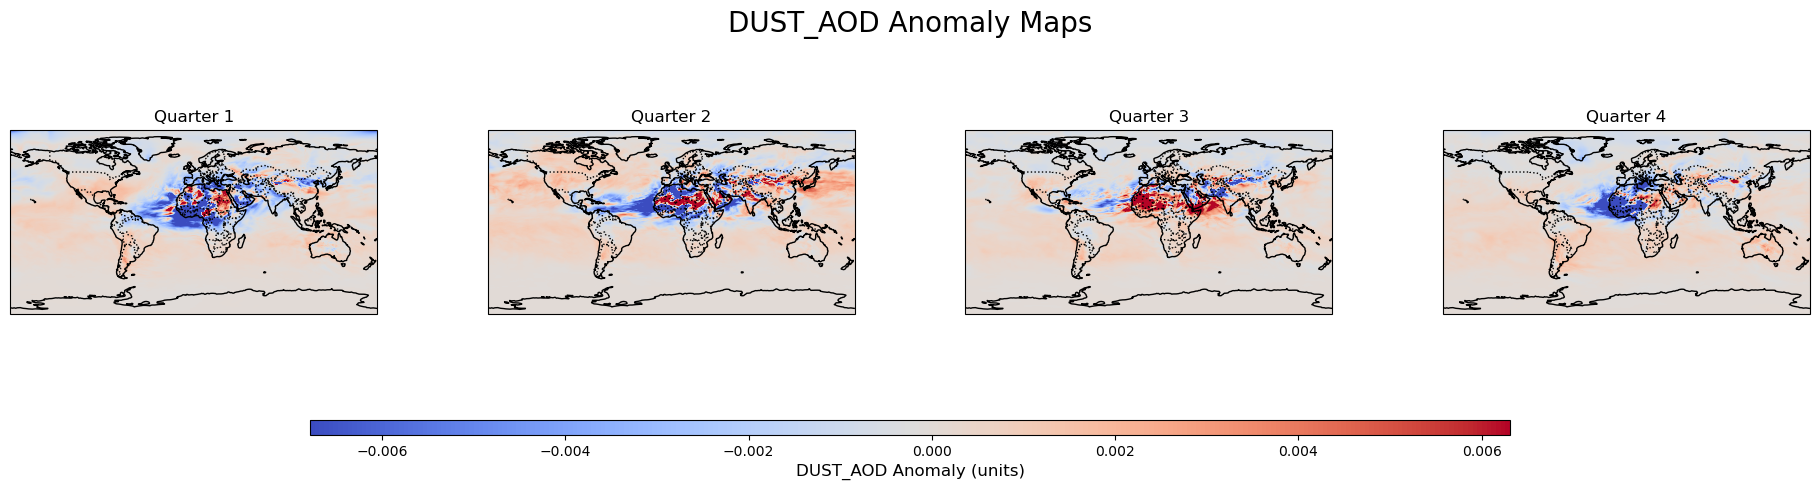

Global dynamic range for PM25: vmin=-1.9961481332778916, vmax=1.9492883682250977


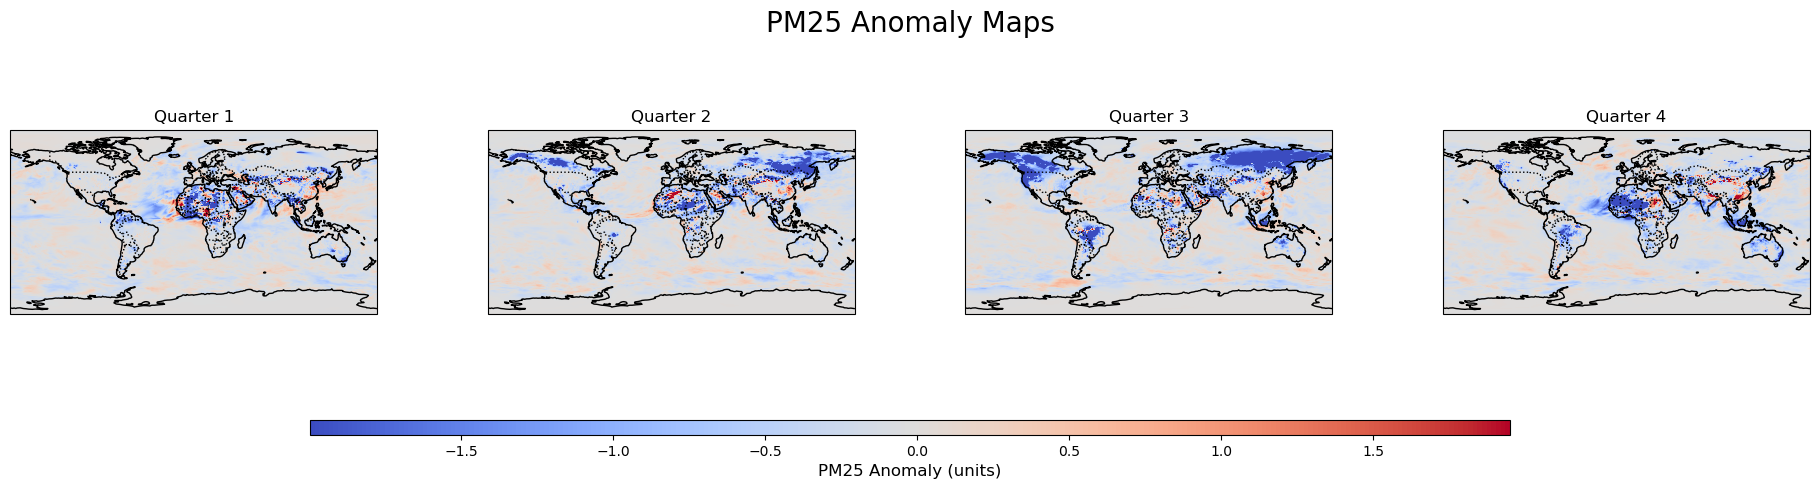

Global dynamic range for PM10: vmin=-5.464034128189084, vmax=5.61729912757869


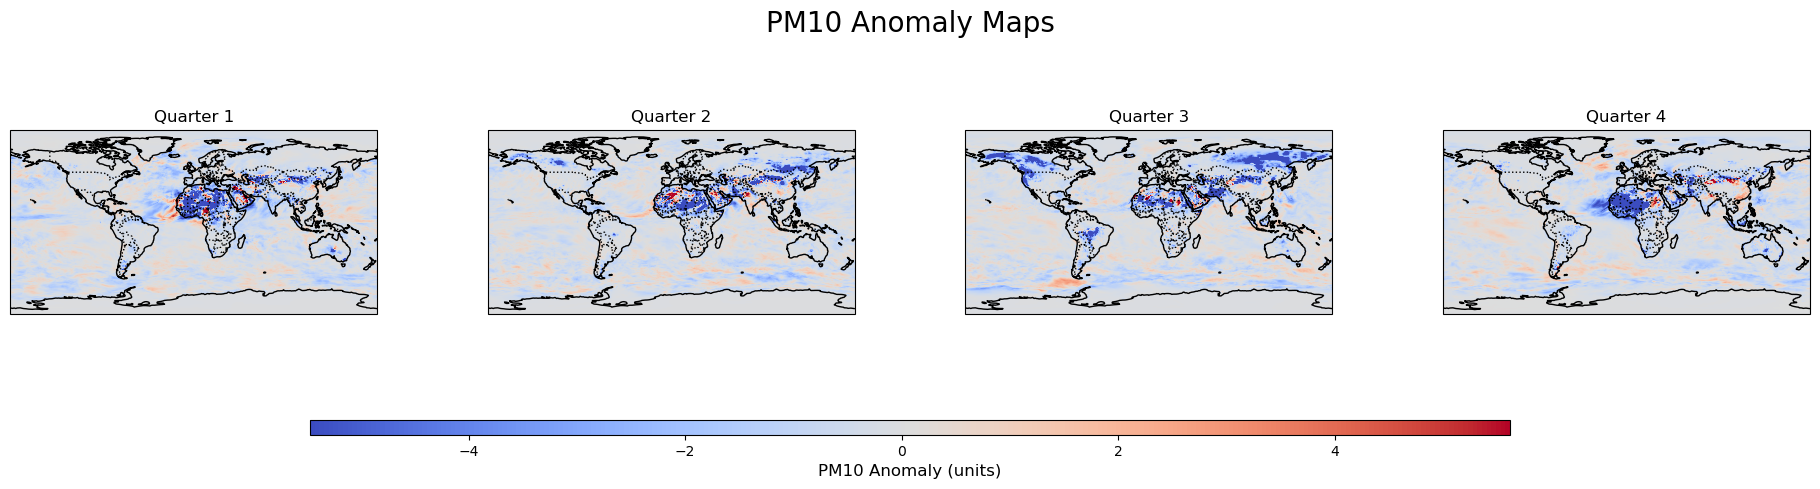

In [27]:
# Calculate global vmin and vmax for each variable
for var in pollution_vars:
    anomaly_data = anomaly_pollution_vars[f"anomaly_{var}"]
    global_vmin = np.percentile(anomaly_data.values.flatten(), 5)
    global_vmax = np.percentile(anomaly_data.values.flatten(), 95)
    print(f"Global dynamic range for {var.upper()}: vmin={global_vmin}, vmax={global_vmax}")

    # Create figure for the current variable
    fig, axs = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': ccrs.PlateCarree()})
    fig.suptitle(f"{var.upper()} Anomaly Maps", fontsize=20, y=0.95)

    # Plot each quarter
    for col_idx, quarter in enumerate(range(1, 5)):
        ax = axs[col_idx]

        # Select data for the current quarter and calculate median
        quarter_data = anomaly_data.sel(time=anomaly_data['time.quarter'] == quarter).median(dim='time')

        # Plot the data
        im = quarter_data.plot(
            ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm',
            vmin=global_vmin, vmax=global_vmax, add_colorbar=False
        )
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.set_title(f"Quarter {quarter}", fontsize=12)

    # Add a colorbar below all the subplots
    cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.03])  # Adjusted position
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(f"{var.upper()} Anomaly (units)", fontsize=12)

    # Adjust layout to avoid using tight_layout
    plt.subplots_adjust(top=0.85, bottom=0.2, left=0.05, right=0.95, wspace=0.3)
    plt.show()


In [7]:
# Set thresholds for positive, negative, and neutral categories
positive_threshold = 0.2  
negative_threshold = -0.2

# Create separate DataFrames for each category
positive = quarterly_data['CFNAI'].where(quarterly_data['CFNAI'] >= positive_threshold)
negative = quarterly_data['CFNAI'].where(quarterly_data['CFNAI'] <= negative_threshold)
neutral = quarterly_data['CFNAI'].where((quarterly_data['CFNAI'] < positive_threshold) & (quarterly_data['CFNAI'] > negative_threshold))

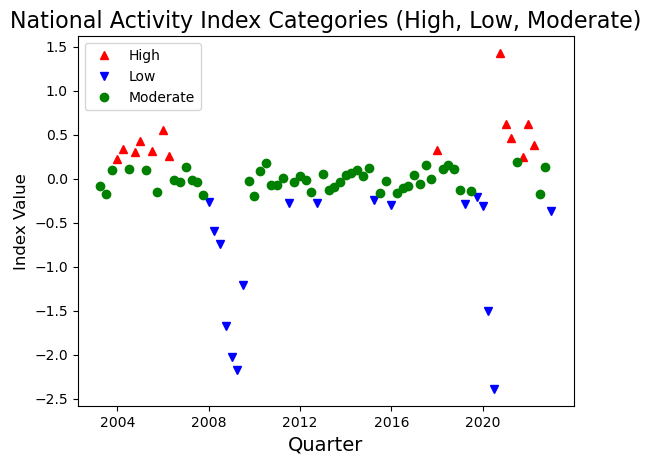

In [13]:
# Plot each category with different markers and colors
plt.plot(quarterly_data['Quarter'], positive, 'r^', label='High')  # Red triangles for positive
plt.plot(quarterly_data['Quarter'], negative, 'bv', label='Low')  # Blue inverted triangles for negative
plt.plot(quarterly_data['Quarter'], neutral, 'go', label='Moderate')  # Green circles for neutral

# Add the legend
plt.legend()

# Add labels and title
plt.title("National Activity Index Categories (High, Low, Moderate)", fontsize=16)
plt.xlabel('Quarter', fontsize=14)
plt.ylabel("Index Value", fontsize=12)

# Show the plot
plt.show()

In [8]:
# Set thresholds for CFNAI categories
positive_threshold2 = 0.1
negative_threshold2 = -0.5

# Create separate categories for CFNAI values
Positive2 = quarterly_data['CFNAI'].where(quarterly_data['CFNAI'] >= positive_threshold2)
Negative2 = quarterly_data['CFNAI'].where(quarterly_data['CFNAI'] <= negative_threshold2)
Neutral2 = quarterly_data['CFNAI'].where((quarterly_data['CFNAI'] < positive_threshold2) & (quarterly_data['CFNAI'] > negative_threshold2))

In [9]:
# Identify dates for each category in CFNAI
positive_periods = quarterly_data['Quarter'][quarterly_data['CFNAI'] >= positive_threshold2].to_numpy()
negative_periods = quarterly_data['Quarter'][quarterly_data['CFNAI'] <= negative_threshold2].to_numpy()
neutral_periods = quarterly_data['Quarter'][(quarterly_data['CFNAI'] < positive_threshold2) & 
                                            (quarterly_data['CFNAI'] > negative_threshold2)].to_numpy()

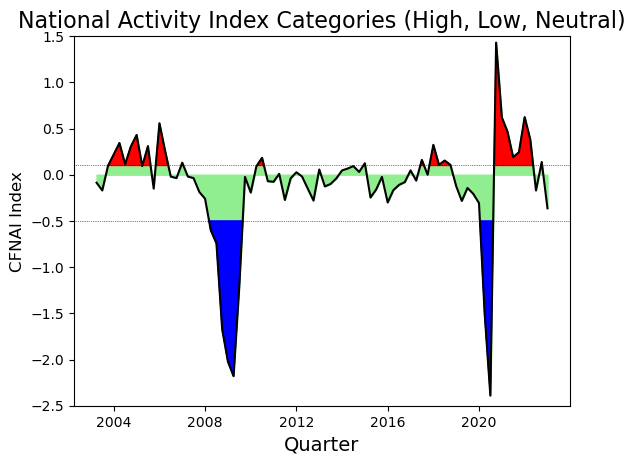

In [16]:
plt.plot(quarterly_data['Quarter'], quarterly_data['CFNAI'], 'k')  # Plot CFNAI time series
plt.fill_between(quarterly_data['Quarter'].values, quarterly_data['CFNAI'], 0, color='lightgreen')  # Neutral region
plt.fill_between(
    quarterly_data['Quarter'].values, quarterly_data['CFNAI'], y2=positive_threshold2,
    where=quarterly_data['CFNAI'] >= positive_threshold2, interpolate=True, color='red'
)  # Positive region
plt.fill_between(
    quarterly_data['Quarter'].values, quarterly_data['CFNAI'], y2=negative_threshold2,
    where=quarterly_data['CFNAI'] <= negative_threshold2, interpolate=True, color='blue'
)  # Negative region

# Add horizontal lines for thresholds
plt.axhline(positive_threshold2, color='black', linewidth=0.5, linestyle='dotted')
plt.axhline(negative_threshold2, color='black', linewidth=0.5, linestyle='dotted')

# Add labels, title, and adjust axes
plt.title("National Activity Index Categories (High, Low, Neutral)", fontsize=16)
plt.xlabel('Quarter', fontsize=14)
plt.ylabel("CFNAI Index", fontsize=12)
plt.ylim([-2.5, 1.5])
plt.show()

In [17]:
# Use the previously calculated anomalies stored in anomaly_pollution_vars
pollution_variables = {
    'pm25': anomaly_pollution_vars['anomaly_pm25'],
    'pm10': anomaly_pollution_vars['anomaly_pm10'],
    'dust_pm25': anomaly_pollution_vars['anomaly_dust_pm25'],
    'dust_pm10': anomaly_pollution_vars['anomaly_dust_pm10'],
    'dust_aod': anomaly_pollution_vars['anomaly_dust_aod']
}

# Dictionary to store composite maps for each variable
composite_maps = {}

# Calculate composite maps for each variable and phase
for var_name, anomaly_data in pollution_variables.items():
    print(f"Calculating composites for {var_name}...")
    
    # Ensure the anomaly data aligns with the time periods
    positive_composite = anomaly_data.sel(time=positive_periods).mean(dim='time')
    negative_composite = anomaly_data.sel(time=negative_periods).mean(dim='time')
    neutral_composite = anomaly_data.sel(time=neutral_periods).mean(dim='time')
    
    # Store the results in the dictionary
    composite_maps[var_name] = {
        'positive': positive_composite,
        'negative': negative_composite,
        'neutral': neutral_composite
    }

# Output the dictionary for verification
for var, composites in composite_maps.items():
    print(f"{var.upper()} composites:")
    for phase, composite in composites.items():
        print(f"  {phase.capitalize()}: {composite}")

Calculating composites for pm25...
Calculating composites for pm10...
Calculating composites for dust_pm25...
Calculating composites for dust_pm10...
Calculating composites for dust_aod...
PM25 composites:
  Positive: <xarray.DataArray 'pm25' (lat: 250, lon: 700)> Size: 700kB
array([[-0.03467339, -0.03318759, -0.03170174, ...,  0.14134796,
         0.14058982,  0.13983114],
       [-0.03763686, -0.03600154, -0.03436637, ...,  0.14103158,
         0.14058208,  0.14013244],
       [-0.04059992, -0.0388154 , -0.03703086, ...,  0.14071609,
         0.14057444,  0.1404332 ],
       ...,
       [ 0.04676463,  0.04808515,  0.04940647, ...,  0.10830238,
         0.11043668,  0.11257114],
       [ 0.04630814,  0.04739783,  0.04848701, ...,  0.09172851,
         0.0939035 ,  0.09607802],
       [ 0.04585147,  0.04670976,  0.0475683 , ...,  0.07515478,
         0.07737011,  0.07958575]], dtype=float32)
Coordinates:
  * lon      (lon) float32 3kB -129.9 -129.9 -129.8 ... -60.25 -60.15 -60.05
  * l

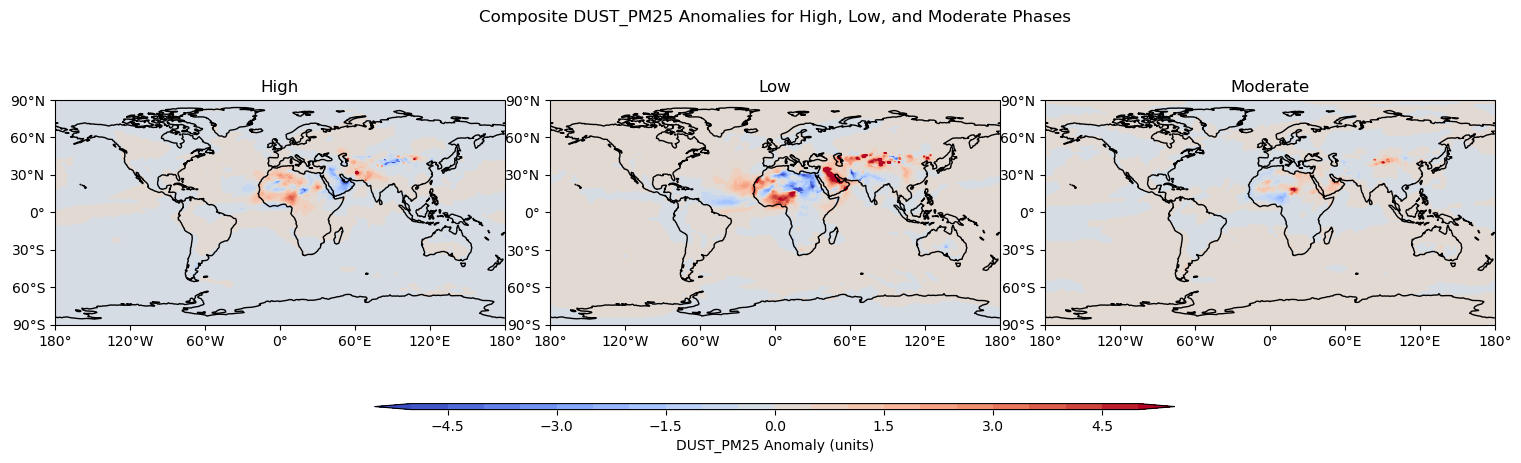

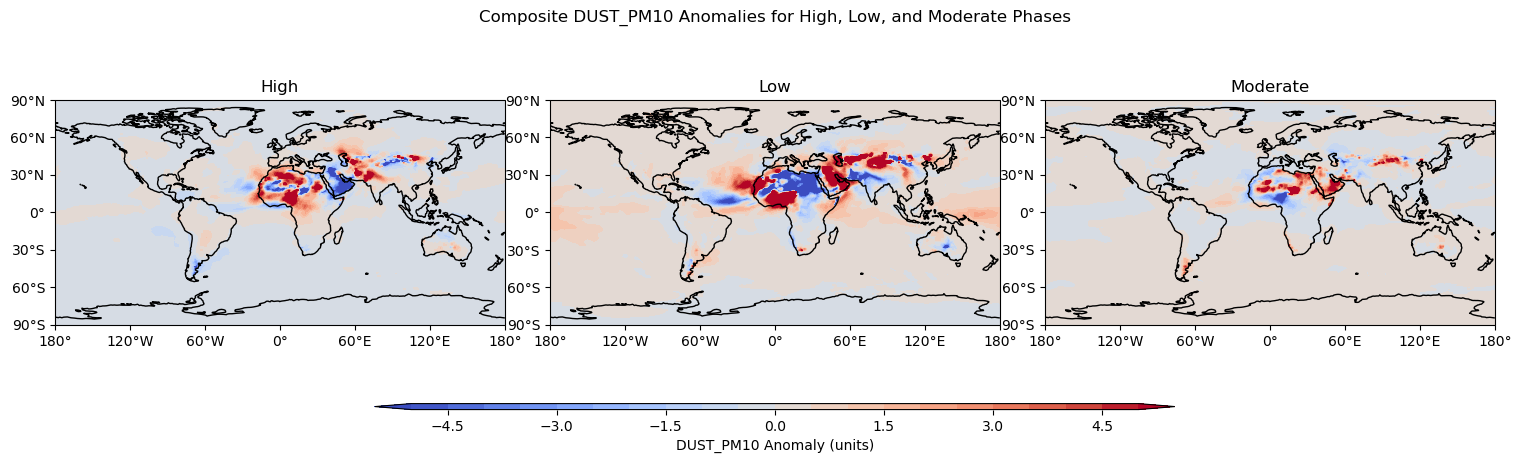

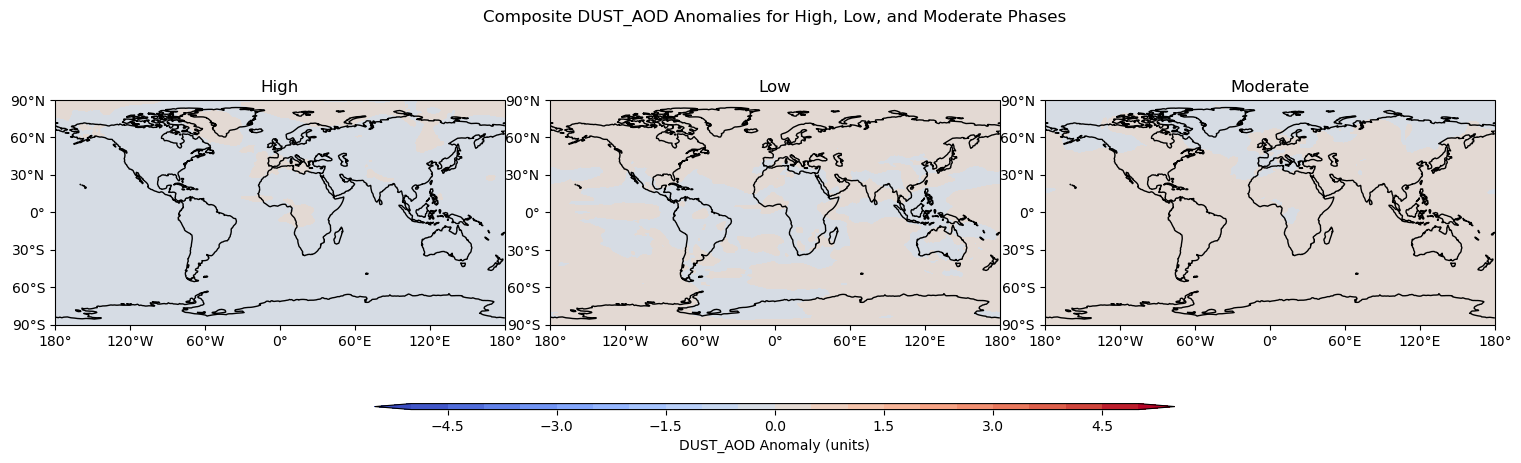

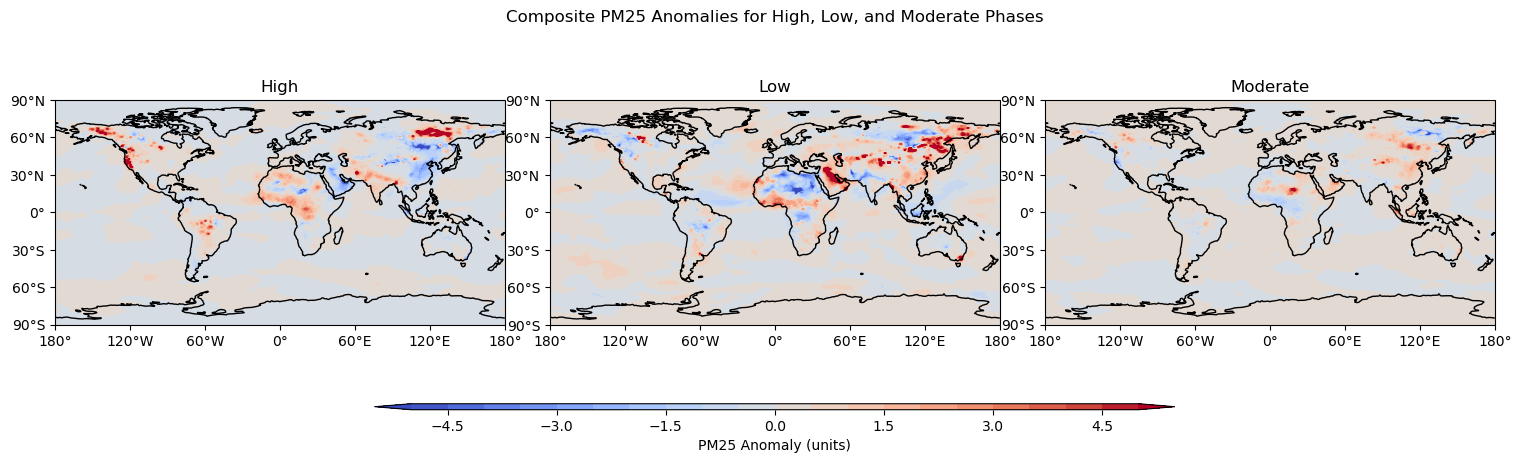

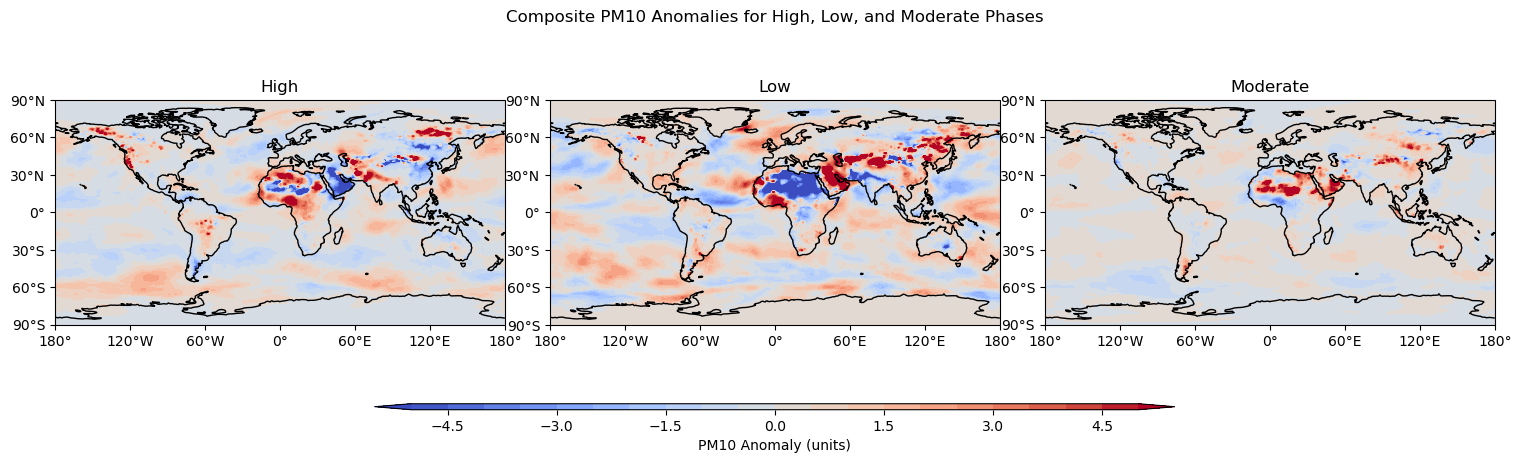

In [36]:
# Labels and contour levels for phases (adjust for your data range)
labels = ['High', 'Low', 'Moderate']
clevs = np.arange(-5, 5.5, 0.5)  # Adjust based on anomaly ranges

# Loop through each pollution variable and plot its composite maps
for var in pollution_vars:  # pollution_vars = ['dust_pm25', 'dust_pm10', 'dust_aod', 'pm25', 'pm10']
    # Access composite maps for the variable
    comp_maps = composite_maps[var]  # composite_maps stores composite maps for all variables
    comp_data = [comp_maps['positive'], comp_maps['negative'], comp_maps['neutral']]

    # Define the figure for the current variable
    fig, axs = plt.subplots(nrows=1, ncols=3,
                            subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(16, 5))
    axs = axs.flatten()  # Flatten the axes array for easy iteration

    # Loop over phases (high, low, neutral)
    for i, phase_data in enumerate(comp_data):
        # Plot the data for the current phase
        cs = axs[i].contourf(
            phase_data['lon'], phase_data['lat'], phase_data,
            clevs, transform=ccrs.PlateCarree(),
            cmap='coolwarm', extend='both'
        )

        # Add longitude and latitude labels
        axs[i].set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        axs[i].set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        # Add title and coastlines to the subplot
        axs[i].set_title(labels[i])
        axs[i].coastlines()

    # Adjust layout to fit the colorbar
    fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95, wspace=0.1, hspace=0.5)

    # Add a colorbar axis at the bottom
    cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])
    cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', label=f'{var.upper()} Anomaly (units)')

    # Add a title for the entire figure
    plt.suptitle(f'Composite {var.upper()} Anomalies for High, Low, and Moderate Phases')

    # Show the plot for the current variable
    plt.show()

Processing DUST_PM25...


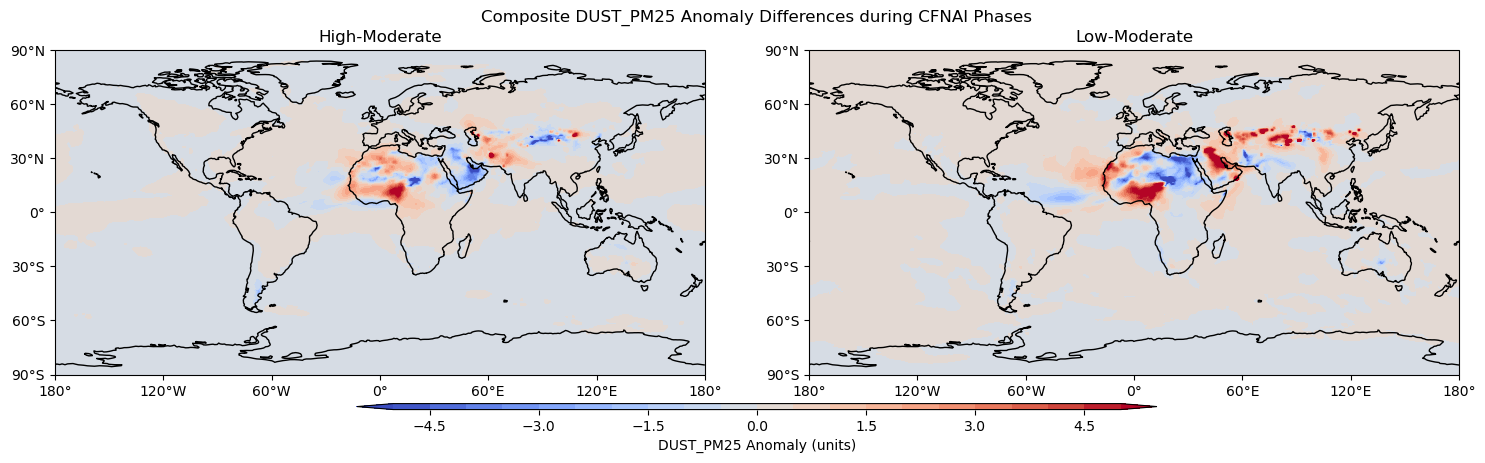

Processing DUST_PM10...


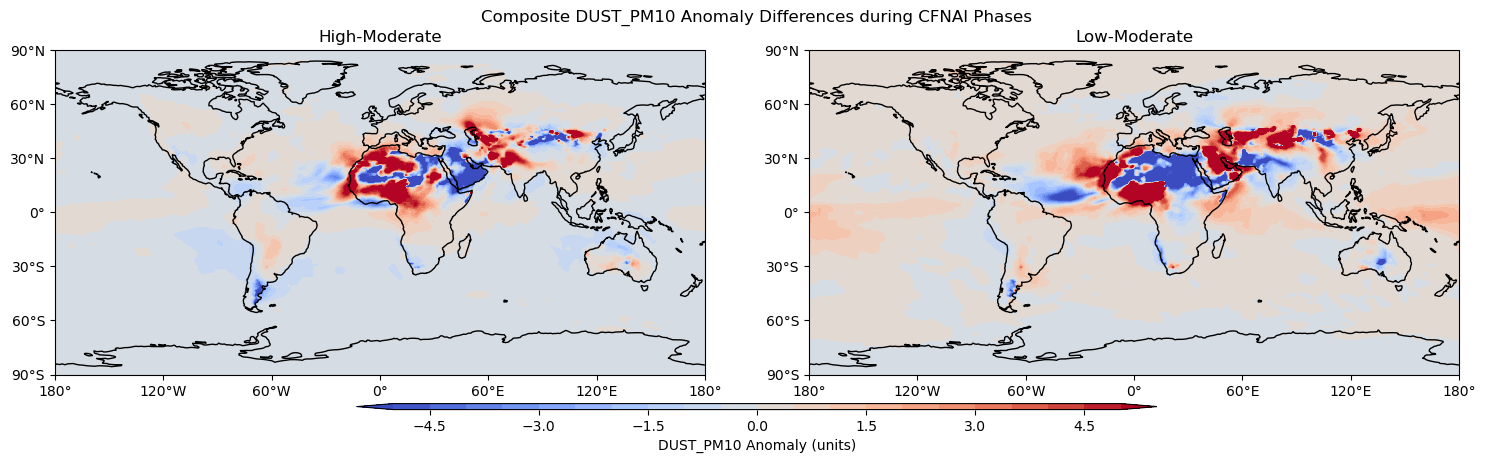

Processing DUST_AOD...


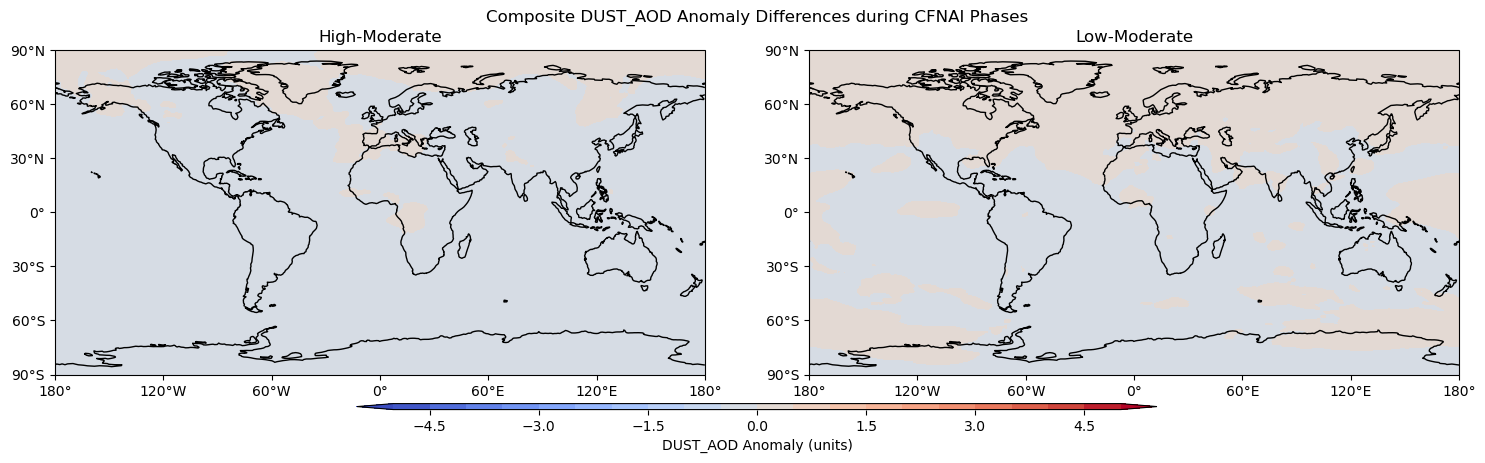

Processing PM25...


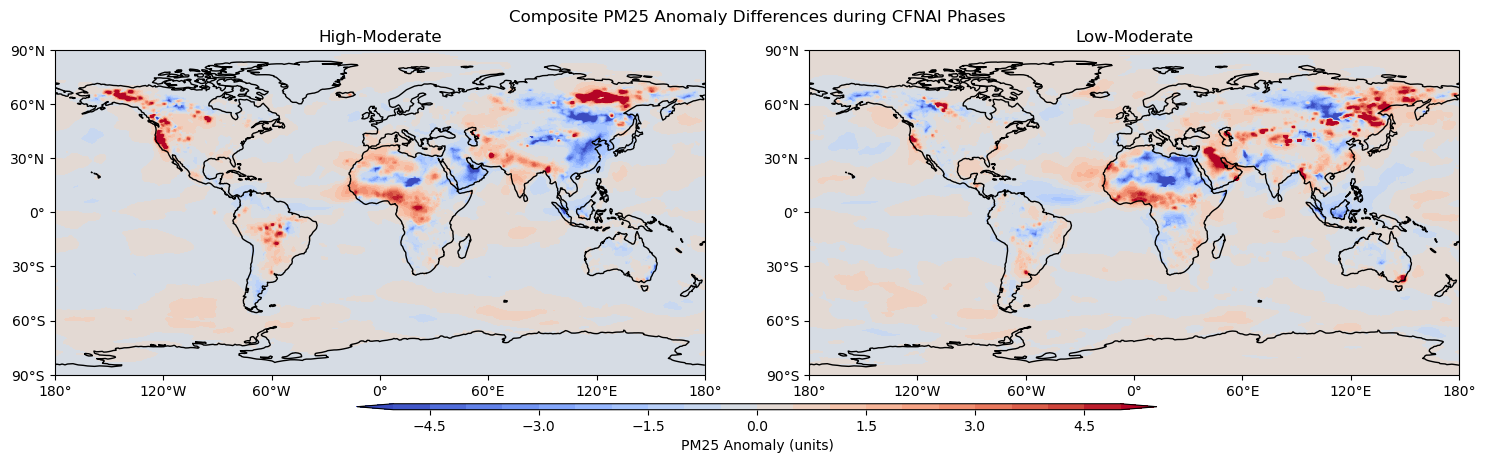

Processing PM10...


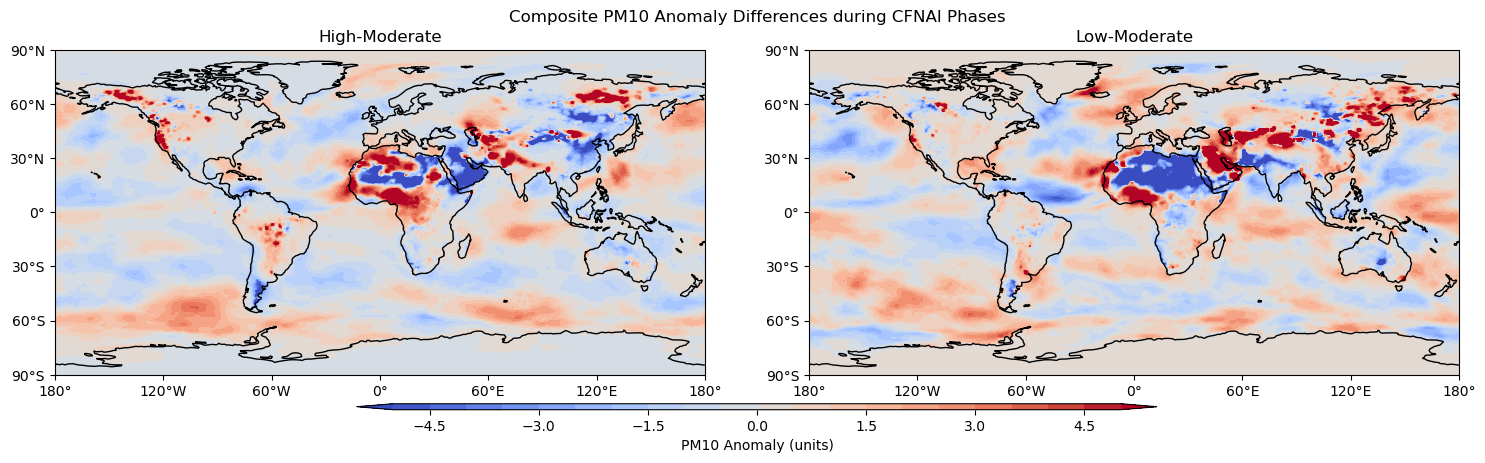

CFNAI Positive Phase Mean: 0.3298611111111111
CFNAI Negative Phase Mean: -1.54125
CFNAI Neutral Phase Mean: -0.09270833333333334
CFNAI Positive-Neutral Difference: 0.42256944444444444
CFNAI Negative-Neutral Difference: -1.4485416666666666


In [38]:
# Calculate composite differences for pollution variables
labels = ['High-Moderate', 'Low-Moderate']
clevs = np.arange(-5, 5.5, 0.5)  # Adjust contour levels as needed

# Loop through pollution variables
for var in pollution_vars:  # pollution_vars includes all pollution variables
    print(f"Processing {var.upper()}...")

    # Calculate the composite differences for this variable
    comp_maps = composite_maps[var]
    diff_data = [
        comp_maps['positive'] - comp_maps['neutral'],  # High - Neutral
        comp_maps['negative'] - comp_maps['neutral']   # Low - Neutral
    ]

    # Define the figure for plotting
    fig, axs = plt.subplots(nrows=1, ncols=2,
                            subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(16, 5))

    # Loop through the differences and plot
    for i, diff in enumerate(diff_data):
        cs = axs[i].contourf(
            diff['lon'], diff['lat'], diff, clevs,
            transform=ccrs.PlateCarree(),
            cmap='coolwarm', extend='both'
        )

        # Add longitude and latitude labels
        axs[i].set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        axs[i].set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        # Add title and coastlines
        axs[i].set_title(labels[i])
        axs[i].coastlines()

    # Add colorbar
    fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95, wspace=0.1, hspace=0.5)
    cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])
    fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', label=f'{var.upper()} Anomaly (units)')

    # Add a title for the figure
    plt.suptitle(f'Composite {var.upper()} Anomaly Differences during CFNAI Phases')
    plt.show()

# Handle CFNAI scalar differences separately
cfnai_positive_mean = Positive2.mean()
cfnai_negative_mean = Negative2.mean()
cfnai_neutral_mean = Neutral2.mean()

print(f"CFNAI Positive Phase Mean: {cfnai_positive_mean}")
print(f"CFNAI Negative Phase Mean: {cfnai_negative_mean}")
print(f"CFNAI Neutral Phase Mean: {cfnai_neutral_mean}")

cfnai_diff_positive = cfnai_positive_mean - cfnai_neutral_mean
cfnai_diff_negative = cfnai_negative_mean - cfnai_neutral_mean

print(f"CFNAI Positive-Neutral Difference: {cfnai_diff_positive}")
print(f"CFNAI Negative-Neutral Difference: {cfnai_diff_negative}")


In [10]:
# Ensure the CFNAI data from quarterly_data matches the time in ds_quarterly
# Convert ds_quarterly time to a pandas DateTimeIndex
ds_quarterly['time'] = pd.to_datetime(ds_quarterly['time'].values)

# Merge the CFNAI data from the quarterly_data DataFrame into the ds_quarterly dataset
ds_quarterly = ds_quarterly.assign_coords(CFNAI=("time", quarterly_data.set_index('Quarter').reindex(ds_quarterly['time'].values)['CFNAI'].values))

# Check that CFNAI is now included in ds_quarterly
print(ds_quarterly)
 
# Use the previously calculated anomalies stored in anomaly_pollution_vars
pollution_vars_anomalies = {
    'dust_pm25': anomaly_pollution_vars['anomaly_dust_pm25'],
    'dust_pm10': anomaly_pollution_vars['anomaly_dust_pm10'],
    'dust_aod': anomaly_pollution_vars['anomaly_dust_aod'],
    'pm25': anomaly_pollution_vars['anomaly_pm25'],
    'pm10': anomaly_pollution_vars['anomaly_pm10']
}

<xarray.Dataset> Size: 10GB
Dimensions:    (lon: 3600, lat: 1800, time: 80)
Coordinates:
  * lon        (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 179.9
  * lat        (lat) float32 7kB -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
  * time       (time) datetime64[ns] 640B 2003-03-31 2003-06-30 ... 2022-12-31
    CFNAI      (time) float64 640B -0.08667 -0.17 0.09667 ... 0.1367 -0.3633
Data variables:
    dust_pm25  (time, lat, lon) float32 2GB ...
    dust_pm10  (time, lat, lon) float32 2GB ...
    dust_aod   (time, lat, lon) float32 2GB ...
    pm25       (time, lat, lon) float32 2GB ...
    pm10       (time, lat, lon) float32 2GB ...


In [ ]:

 # Loop through each pollution variable anomaly and perform regression
for var, da_anoms in pollution_vars_anomalies.items():
    print(f"Processing anomaly variable: {var.upper()}")
    
    # Independent variable: CFNAI index
    cfna_index = ds_quarterly['CFNAI'].values  # Ensure this is aligned with time dimension

    # Get grid size
    nx = len(da_anoms['lon'])
    ny = len(da_anoms['lat'])

    # Initialize empty arrays for regression results
    p_array = np.full((ny, nx), np.nan)   # p-values
    r_array = np.full((ny, nx), np.nan)   # correlation coefficients
    m_array = np.full((ny, nx), np.nan)   # slopes of regression lines

    # Loop through each grid cell
    for j in range(ny):
        for i in range(nx):
            # Dependent variable: time series for the grid cell
            y = da_anoms[:, j, i].values

            # Skip grid cells with all NaN values
            if np.all(np.isnan(y)):
                continue

            # Perform linear regression
            m, b, r, p, _ = linregress(cfna_index, y)

            # Store regression results
            p_array[j, i] = p
            r_array[j, i] = r
            m_array[j, i] = m

    print("*** DONE ***")
 # Mask slope values where p > 0.05 (not statistically significant)
    mask_sig = np.where(p_array < 0.05, m_array, np.nan)

    # Add cyclic points for smooth global plotting
    data, lon = add_cyclic_point(m_array, coord=da_anoms['lon'])
    mask_data, _ = add_cyclic_point(mask_sig, coord=da_anoms['lon'])

    # Plot the regression map
    clevs = np.arange(-3, 3.25, 0.25)  # Fixed contour levels
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=200))
    cs = ax.contourf(lon, da_anoms['lat'], data, clevs, transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')

    # Overlay significant areas with hatching
    ax.contourf(lon, da_anoms['lat'], mask_data, levels=[0, 1], transform=ccrs.PlateCarree(), colors='none', hatches=['..'], alpha=0)

    # Add map features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False

    # Add colorbar
    cbar = plt.colorbar(cs, orientation='horizontal', pad=0.05, aspect=50)
    cbar.set_label(f"Regression Coefficient: {var.upper()} Anomaly vs. CFNAI")

    # Add title
    plt.title(f"Regression between CFNAI and {var.upper()} Anomalies", fontsize=16)
    plt.show()

![Waiting time to get the output](clim680.png)

The long computational time experienced in the initial stages of this study was primarily due to the high spatial resolution and irregular structure of the original anomaly datasets, such as PM2.5 anomalies. Processing these high-resolution data for global-scale regression analyses was computationally intensive, as it involved a large number of grid points and increased memory requirements. This significantly slowed down the analysis pipeline, particularly when iterating through each grid point to calculate statistical relationships with indices like the Chicago Fed National Activity Index (CFNAI). Additionally, the irregular grid structure posed challenges in producing seamless visualizations and aligning the data with coarser-resolution indices, further adding to the processing time and complexity.

To address these issues and optimize the workflow, the anomaly data were regridded onto a coarser, uniform 1° × 1° latitude-longitude grid. This regridding process reduced the number of grid points, thereby shortening the runtime for statistical analyses and enabling smoother handling of the data. Beyond computational efficiency, regridding provided a harmonized spatial framework, ensuring compatibility with other datasets and facilitating global-scale comparisons. While regridding inherently involves some loss of spatial detail, the process carefully preserved the key spatial patterns and variability in the anomalies, ensuring that the results remain robust and scientifically meaningful. This approach not only made the analyses feasible within reasonable computational time but also improved the clarity and interpretability of the regression maps and other visual outputs.

In [ ]:
# Ensure the CFNAI data from quarterly_data matches the time in ds_quarterly
# Convert ds_quarterly time to a pandas DateTimeIndex
ds_quarterly['time'] = pd.to_datetime(ds_quarterly['time'].values)

# Select a spatial region (the US)
ds_quarterly = ds_quarterly.sel(lat=slice(25, 50), lon=slice(-130, -60))

# Merge the CFNAI data from the quarterly_data DataFrame into the ds_quarterly dataset
ds_quarterly = ds_quarterly.assign_coords(
    CFNAI=("time", quarterly_data.set_index('Quarter').reindex(ds_quarterly['time'].values)['CFNAI'].values)
)

# Check that CFNAI is now included in ds_quarterly
print(ds_quarterly)

In [ ]:
# Use the previously calculated anomalies stored in `anomaly_pollution_vars`
pollution_vars_anomalies = {
    'dust_pm25': anomaly_pollution_vars['anomaly_dust_pm25'],
    'dust_pm10': anomaly_pollution_vars['anomaly_dust_pm10'],
    'dust_aod': anomaly_pollution_vars['anomaly_dust_aod'],
    'pm25': anomaly_pollution_vars['anomaly_pm25'],
    'pm10': anomaly_pollution_vars['anomaly_pm10']
}

In [9]:
# Loop through each pollution variable anomaly and perform regression
for var, da_anoms in pollution_vars_anomalies.items():
    print(f"Processing anomaly variable: {var.upper()}")
    
    # Independent variable: CFNAI index
    cfna_index = ds_quarterly['CFNAI'].values  # Ensure this is aligned with time dimension

    # Get grid size
    nx = len(da_anoms['lon'])
    ny = len(da_anoms['lat'])

    # Initialize empty arrays for regression results
    p_array = np.full((ny, nx), np.nan)   # p-values
    r_array = np.full((ny, nx), np.nan)   # correlation coefficients
    m_array = np.full((ny, nx), np.nan)   # slopes of regression lines

Processing anomaly variable: DUST_PM25
Processing anomaly variable: DUST_PM10
Processing anomaly variable: DUST_AOD
Processing anomaly variable: PM25
Processing anomaly variable: PM10


In [10]:
from joblib import Parallel, delayed
import numpy as np

# Function to process a single grid point
def process_grid_point(j, i):
    y = da_anoms[:, j, i].values
    if np.all(np.isnan(y)):
        return np.nan, np.nan, np.nan  # Return NaNs if the grid point is invalid
    m, b, r, p, _ = linregress(cfna_index, y)
    return m, r, p  # Return regression results

# Parallel processing for each grid point
print("Starting parallel processing...")
results = Parallel(n_jobs=-1)(  # Use all available CPUs
    delayed(process_grid_point)(j, i)
    for j in range(ny)
    for i in range(nx)
)

# Reshape results back into arrays
m_array = np.array([res[0] for res in results]).reshape(ny, nx)
r_array = np.array([res[1] for res in results]).reshape(ny, nx)
p_array = np.array([res[2] for res in results]).reshape(ny, nx)

print("*** Parallel processing DONE ***")

Starting parallel processing...
*** Parallel processing DONE ***


In [11]:
# Define the target longitude grid
regridded_lon = np.linspace(-179.95, 179.95, num=360)  # Regular 1-degree spacing

# Ensure longitude is 1D and matches m_array's shape
original_lon = da_anoms["lon"].values
print(f"Original longitude shape: {original_lon.shape}")
print(f"m_array shape: {m_array.shape}")

# Check if the lengths match
if len(original_lon) != m_array.shape[1]:
    print("Error: Longitude lengths do not match the data. Fixing longitude dimension.")
    original_lon = np.linspace(original_lon.min(), original_lon.max(), m_array.shape[1])

# Initialize empty arrays for regridded data
m_array_regridded = np.empty((m_array.shape[0], len(regridded_lon)))
p_array_regridded = np.empty((p_array.shape[0], len(regridded_lon)))

# Perform interpolation for each latitude slice
for lat_idx in range(m_array.shape[0]):  # Iterate over latitude slices
    m_array_regridded[lat_idx, :] = np.interp(
        regridded_lon, original_lon, m_array[lat_idx, :], period=360
    )
    p_array_regridded[lat_idx, :] = np.interp(
        regridded_lon, original_lon, p_array[lat_idx, :], period=360
    )

# Convert regridded arrays back to DataArrays
m_array_da = xr.DataArray(
    m_array_regridded,
    dims=["lat", "lon"],
    coords={"lat": da_anoms["lat"].values, "lon": regridded_lon},
)
p_array_da = xr.DataArray(
    p_array_regridded,
    dims=["lat", "lon"],
    coords={"lat": da_anoms["lat"].values, "lon": regridded_lon},
)

# Continue with plotting or analysis
print("Regridding complete. Ready for further analysis or plotting.")

Original longitude shape: (3600,)
m_array shape: (1800, 3600)
Regridding complete. Ready for further analysis or plotting.


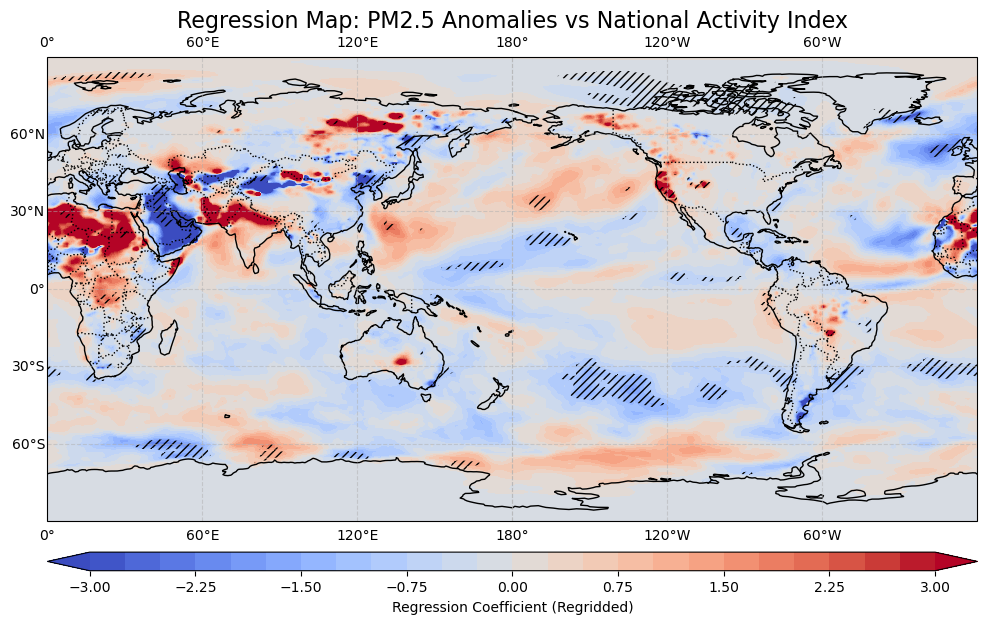

In [32]:
# Ensure longitude alignment for cyclic points
from cartopy.util import add_cyclic_point

# Mask slope values where p > 0.05 (not statistically significant)
mask_data = np.where(p_array_da < 0.05, 1, 0)  # Binary mask for significance

# Add cyclic points to handle global plotting smoothly
data, cyclic_lon = add_cyclic_point(m_array_da.values, coord=m_array_da['lon'].values)
mask_data, cyclic_lon = add_cyclic_point(mask_data, coord=m_array_da['lon'].values)

# Plot the regression map
clevs = np.arange(-3, 3.25, 0.25)  # Fixed contour levels
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
cs = ax.contourf(
    cyclic_lon, m_array_da['lat'].values, data, clevs, 
    transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both'
)

# Overlay significant areas with hatching
ax.contourf(
    cyclic_lon, m_array_da['lat'].values, mask_data, levels=[0.5, 1.5],  # Binary mask levels
    transform=ccrs.PlateCarree(), colors='none', hatches=['////'], alpha=0
)

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.xlabels_top = False
gl.ylabels_right = False

# Add colorbar
cbar = plt.colorbar(cs, orientation='horizontal', pad=0.05, aspect=50)
cbar.set_label("Regression Coefficient (Regridded)")

# Add title
plt.title("Regression Map: PM2.5 Anomalies vs National Activity Index", fontsize=16)
plt.show()

The above regression map illustrates the relationship between regridded PM2.5 anomalies and the National Activity Index (NAI). The shading represents the regression coefficients, where ***warm colors (red)*** indicate positive correlations—an increase in economic activity correlating with higher PM2.5 anomalies—***and cool colors (blue)*** indicate negative correlations. 
Significant relationships (p<0.05) are highlighted with hatching. For example, regions such as northern Africa exhibit strong positive coefficients, suggesting that economic activity in these areas may contribute to higher PM2.5 concentrations, potentially due to industrial and agricultural emissions. Conversely, the Middle East predominantly shows negative regression coefficients (blue), which may indicate that increases in economic activity correlate with reduced PM2.5 anomalies. This could reflect the region’s specific meteorological patterns, emissions reduction measures, or other mitigating factors.

This map highlights the complexity of the economic activity-air quality relationship, which varies significantly across the globe. Regions like Eastern Asia show positive correlations, emphasizing the impact of industrial activity on air quality, whereas areas such as the Southern Hemisphere and the Middle East display significant negative correlations. These findings suggest that local factors, including emission regulations, atmospheric conditions, or industrial composition, play a critical role in shaping the observed relationships. This spatial variability underscores the need for region-specific air quality management and economic planning to address the intertwined challenges of pollution and development effectively.

The Middle East and its reliance on oil could be a contributing factor to the negative regression coefficients (blue) observed in the region, but let me break it down further:

**Economic Activity and PM2.5 in the Middle East:**
The Middle East is a region heavily reliant on oil production and export as a primary driver of its economy. Unlike regions where industrial activity, manufacturing, or urbanization directly contribute to increased PM2.5 emissions, much of the economic activity in the Middle East might not directly increase localized air pollution in the same way. Oil extraction and export typically occur in less densely populated areas (e.g., deserts), which may lead to a weaker or even inverse relationship between economic activity and PM2.5 levels in urban areas.
Additionally, economic activity in the region often involves oil refining and energy production that might already operate under strict emission controls, particularly in wealthier nations like Saudi Arabia or the UAE, which invest in cleaner technologies or carbon capture strategies. This might lead to reduced PM2.5 emissions despite increased economic activity.

**Meteorological and Natural Dust Contributions:**
The Middle East is naturally prone to dust storms and desert aerosols, which dominate the PM2.5 composition. These natural dust contributions are often less influenced by human economic activity and more dependent on weather conditions, such as wind speeds and dryness. Increased economic activity may correspond with investments in dust mitigation measures (e.g., vegetation projects or water sprinkling), which could reduce dust-related PM2.5.
Moreover, a significant portion of PM2.5 in the Middle East comes from natural sources, meaning that anthropogenic emissions (from vehicles, industries, etc.) could play a relatively smaller role. This would further weaken or invert the relationship between economic activity and PM2.5 concentrations.